# NET PROFIT PREDICTION

In [1]:
%matplotlib inline

# import warnings filter
from warnings import simplefilter

# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

## Load data

In [2]:
import pandas as pd

# load training data
full_train = pd.read_csv("data/train/train.csv")

# load testing data
test = pd.read_csv("data/test/test.csv")

## 数据归一化及数据集拆分

In [3]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
import category_encoders as ce
from sklearn.utils import shuffle

full_train_X = full_train[full_train.columns.drop(["净利润_2017"])]
full_train_y = full_train["净利润_2017"]

# 2017年净利润归一化（Min-Max Normalization：x' = (x - X_min) / (X_max - X_min)）
norm_full_train_y = (full_train_y - full_train_y.min()) / (full_train_y.max() - full_train_y.min())

# 划分测试集和验证集
train_X, valid_X, train_y, valid_y = train_test_split(full_train_X, norm_full_train_y, random_state=66)

## XGBoost (eXtreme Gradient Boosting)
> **XGBoost 是一个开源软件库**，它为 C++、Java、Python、R、和Julia提供了一个**梯度提升框架**，适用于Linux、Windows、和 mac os。根据项目的描述，它的目的在于提供一个"可扩展、可移植和分布式梯度提升(GBM、GBRT、GBDT)库"。 XGBoost除了可以在单一机器上运行，也支持运行在分布式框架Apache Hadoop、Apache Spark、Apache Flink。 近几年，由于这个算法受到许多在机器学习竞赛中获奖团队的青睐，因而受到了广泛的欢迎和关注。[wiki](https://zh.wikipedia.org/wiki/XGBoost)

### Gradient boosting
> 梯度提升（梯度增强）是一种用于回归和分类问题的机器学习技术，**其产生的预测模型是弱预测模型的集成**，如采用典型的**决策树** 作为**弱预测模型**，这时则为**梯度提升树（GBT或GBDT**）。像其他提升方法一样，它以**分阶段的方式构建模型**，但它**通过允许对任意可微分损失函数进行优化**作为对一般提升方法的推广。  
梯度提升的思想源自Leo Breiman的一个观察：即可以**将提升方法解释为针对适当成本函数的优化算法**。[wiki](https://zh.wikipedia.org/wiki/%E6%A2%AF%E5%BA%A6%E6%8F%90%E5%8D%87%E6%8A%80%E6%9C%AF)

**XGBoost 所应用的算法就是 gradient boosting decision tree**，既可以用于分类也可以用于回归问题中。

#### Boosting三要素
所谓 **Boosting** ，就是将**弱分离器 $f_i(x)$ 组合起来形成强分类器 $F(x)$ 的一种方法**。
1. A loss function to be optimized （例如：回归问题用 mean squared error）
2. A weak learner to make predictions （例如：决策树）
3. An additive model （将多个弱学习器累加起来组成强学习器，进而使目标损失函数达到极小。）

Gradient boosting 就是通过**加入新的弱学习器，来努力纠正前面所有弱学习器的残差**，最终这样多**个学习器相加在一起用来进行最终预测**，准确率就会比单独的一个要高。之所以称为 Gradient，是因为在添加新模型时使用了**梯度下降算法来最小化的损失**。

In [4]:
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import ShuffleSplit
from sklearn.utils import shuffle

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [5]:
def train_xgb(train_X, train_y, valid_X, valid_y, test_X, index='xgb_01'):
    # 模型定义
    xgb_model = XGBRegressor(colsample_bytree=0.4,
                 gamma=0.05,                 
                 learning_rate=0.05,
                 max_depth=20,
                 min_child_weight=1.5,
                 n_estimators=500,                                                                    
                 reg_alpha=0.65,
                 reg_lambda=0.5,
                 subsample=0.95)
    

    # 模型训练
    xgb_model.fit(train_X, train_y, 
                 early_stopping_rounds=5, 
                 eval_set=[(valid_X, valid_y)], 
                 verbose=False)

    # 模型预测
    pred_y = xgb_model.predict(valid_X)
    
    # 评估标准
    # 1. mae
    mae_score = mean_absolute_error(valid_y, pred_y)
    
    # 2. mape
    mape_score = mean_absolute_percentage_error(valid_y, pred_y)

    # 3. mse
    mse_score = mean_squared_error(valid_y, pred_y)
    
    # 4. rmse
    rmse_score = mean_squared_error(valid_y, pred_y, squared=False)
    
    # 5. r-2 score
    r_2_score = r2_score(valid_y, pred_y)

    
    print("Mean Absolute Error(平均绝对误差):" , np.round(mae_score, 6))
    print("Mean Absolute Percentage Error(平均绝对百分比误差):" , np.round(mape_score, 6))
    print("Mean Squared Error(均方误差):" , np.round(mse_score, 6))
    print("Root Squared Error(均方根误差):" , np.round(rmse_score, 6))
    print("r-2 score:" , np.round(r_2_score, 6))
    
    # 测试集预测
    test_pred_y = xgb_model.predict(test_X)
    test_result = test[['ID']].join(pd.DataFrame({'净利润': np.round(test_pred_y, 6)}))
    
    # 保存预测结果到txt文档
    test_result.to_csv('201952110323+谭凯悦_%s.txt'%(index), sep=',', index=False)
    
    return mae_score, mape_score, mse_score, rmse_score, r_2_score

## LightGBM

In [6]:
import lightgbm as lgb

/usr/local/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [7]:
def train_gbm(train_X, train_y, valid_X, valid_y, test_X, index='gbm_01'):
    hyper_params = {
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'metric': ['l2', 'auc'],
        'learning_rate': 0.01,
        'feature_fraction': 0.9,
        'bagging_fraction': 0.7,
        'bagging_freq': 10,
        'verbose': 0,
        "max_depth": 8,
        "num_leaves": 110,  
        "max_bin": 512,
        "num_iterations": 1000,
        "n_estimators": 100
    }

    gbm = lgb.LGBMRegressor(**hyper_params)
    
    gbm.fit(train_X, train_y,
        eval_set=[(valid_X, valid_y)],
        eval_metric='l1',
        early_stopping_rounds=1000)
    
    
    pred_y = gbm.predict(valid_X, num_iteration=gbm.best_iteration_)
    
    # 评估标准
    # 1. mae
    mae_score = mean_absolute_error(valid_y, pred_y)
    
    # 2. mape
    mape_score = mean_absolute_percentage_error(valid_y, pred_y)

    # 3. mse
    mse_score = mean_squared_error(valid_y, pred_y)
    
    # 4. rmse
    rmse_score = mean_squared_error(valid_y, pred_y, squared=False)
    
    # 5. r-2 score
    r_2_score = r2_score(valid_y, pred_y)

    
    print("Mean Absolute Error(平均绝对误差):" , np.round(mae_score, 6))
    print("Mean Absolute Percentage Error(平均绝对百分比误差):" , np.round(mape_score, 6))
    print("Mean Squared Error(均方误差):" , np.round(mse_score, 6))
    print("Root Squared Error(均方根误差):" , np.round(rmse_score, 6))
    print("r-2 score:" , np.round(r_2_score, 6))
    
    # 测试集预测
    test_pred_y = gbm.predict(test_X, num_iteration=gbm.best_iteration_)
    test_result = test[['ID']].join(pd.DataFrame({'净利润': np.round(test_pred_y, 6)}))
    
    # 保存预测结果到txt文档
    test_result.to_csv('201952110323+谭凯悦_%s.txt'%(index), sep=',', index=False)
    
    return mae_score, mape_score, mse_score, rmse_score, r_2_score
    

## Linear Regression

In [8]:
from sklearn.linear_model import LinearRegression

In [9]:
def train_lr(train_X, train_y, valid_X, valid_y, test_X, index='lr_01'):
    # Create linear regression object
    lr = LinearRegression()

    # Train the model using the training sets
    lr.fit(train_X, train_y)

    # Make predictions using the validation set
    pred_y = lr.predict(valid_X)
    
    # Plot outputs
    # 评估标准
    # 1. mae
    mae_score = mean_absolute_error(valid_y, pred_y)
    
    # 2. mape
    mape_score = mean_absolute_percentage_error(valid_y, pred_y)

    # 3. mse
    mse_score = mean_squared_error(valid_y, pred_y)
    
    # 4. rmse
    rmse_score = mean_squared_error(valid_y, pred_y, squared=False)
    
    # 5. r-2 score
    r_2_score = r2_score(valid_y, pred_y)

    
    print("Mean Absolute Error(平均绝对误差):" , np.round(mae_score, 6))
    print("Mean Absolute Percentage Error(平均绝对百分比误差):" , np.round(mape_score, 6))
    print("Mean Squared Error(均方误差):" , np.round(mse_score, 6))
    print("Root Squared Error(均方根误差):" , np.round(rmse_score, 6))
    print("r-2 score:" , np.round(r_2_score, 6))
    
    # 测试集预测
    test_pred_y = lr.predict(test_X)
    test_result = test[['ID']].join(pd.DataFrame({'净利润': np.round(test_pred_y, 6)}))
    
    # 保存预测结果到txt文档
    test_result.to_csv('201952110323+谭凯悦_%s.txt'%(index), sep=',', index=False)
    
    return mae_score, mape_score, mse_score, rmse_score, r_2_score

### 删除类别数据，并且不做任何特征优化和选择

In [10]:
# 删除类别特征
train_X_1 = train_X[train_X.columns.drop(["行业", "区域", "企业类型", "控制人类型"])]
valid_X_1 = valid_X[valid_X.columns.drop(["行业", "区域", "企业类型", "控制人类型"])]
test_X_1 = test[test.columns.drop(["行业", "区域", "企业类型", "控制人类型"])]

In [11]:
# XGBoost
_ = train_xgb(train_X_1, train_y, valid_X_1, valid_y, test_X_1, 'xgb_01')  # 0.03884 -> 0.03868 (调整模型参数)

Mean Absolute Error(平均绝对误差): 0.03868
Mean Absolute Percentage Error(平均绝对百分比误差): 14.48261
Mean Squared Error(均方误差): 0.004203
Root Squared Error(均方根误差): 0.064832
r-2 score: 0.09316


In [12]:
# LightGBM
_ = train_gbm(train_X_1, train_y, valid_X_1, valid_y, test_X_1, 'gbm_01') # 0.041719

/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l1: 0.0417189	valid_0's l2: 0.00462669	valid_0's auc: 1
Training until validation scores don't improve for 1000 rounds.
[2]	valid_0's l1: 0.0416559	valid_0's l2: 0.00461538	valid_0's auc: 1
[3]	valid_0's l1: 0.0415916	valid_0's l2: 0.00460479	valid_0's auc: 1
[4]	valid_0's l1: 0.0415335	valid_0's l2: 0.00459715	valid_0's auc: 1
[5]	valid_0's l1: 0.0414672	valid_0's l2: 0.00458673	valid_0's auc: 1
[6]	valid_0's l1: 0.0414113	valid_0's l2: 0.00457845	valid_0's auc: 1
[7]	valid_0's l1: 0.041359	valid_0's l2: 0.0045711	valid_0's auc: 1
[8]	valid_0's l1: 0.0412978	valid_0's l2: 0.00456331	valid_0's auc: 1
[9]	valid_0's l1: 0.0412462	valid_0's l2: 0.00455614	valid_0's auc: 1
[10]	valid_0's l1: 0.0411849	valid_0's l2: 0.00454669	valid_0's auc: 1
[11]	valid_0's l1: 0.0411245	valid_0's l2: 0.00453808	valid_0's auc: 1
[12]	valid_0's l1: 0.0410717	valid_0's l2: 0.00453112	valid_0's auc: 1
[13]	valid_0's l1: 0.0410105	valid_0's l2: 0.00452253	valid_0's auc: 1
[14]	valid_0's l1: 0.040

[121]	valid_0's l1: 0.0382666	valid_0's l2: 0.00418395	valid_0's auc: 1
[122]	valid_0's l1: 0.0382556	valid_0's l2: 0.0041827	valid_0's auc: 1
[123]	valid_0's l1: 0.0382482	valid_0's l2: 0.00418167	valid_0's auc: 1
[124]	valid_0's l1: 0.0382383	valid_0's l2: 0.0041806	valid_0's auc: 1
[125]	valid_0's l1: 0.0382343	valid_0's l2: 0.0041799	valid_0's auc: 1
[126]	valid_0's l1: 0.0382268	valid_0's l2: 0.00417841	valid_0's auc: 1
[127]	valid_0's l1: 0.0382174	valid_0's l2: 0.00417727	valid_0's auc: 1
[128]	valid_0's l1: 0.0382125	valid_0's l2: 0.00417634	valid_0's auc: 1
[129]	valid_0's l1: 0.0382052	valid_0's l2: 0.00417547	valid_0's auc: 1
[130]	valid_0's l1: 0.0381991	valid_0's l2: 0.00417487	valid_0's auc: 1
[131]	valid_0's l1: 0.038194	valid_0's l2: 0.00417464	valid_0's auc: 1
[132]	valid_0's l1: 0.0381858	valid_0's l2: 0.0041739	valid_0's auc: 1
[133]	valid_0's l1: 0.0381835	valid_0's l2: 0.00417369	valid_0's auc: 1
[134]	valid_0's l1: 0.0381789	valid_0's l2: 0.00417381	valid_0's auc:

[236]	valid_0's l1: 0.0378654	valid_0's l2: 0.00416078	valid_0's auc: 1
[237]	valid_0's l1: 0.037866	valid_0's l2: 0.00416041	valid_0's auc: 1
[238]	valid_0's l1: 0.0378651	valid_0's l2: 0.00416031	valid_0's auc: 1
[239]	valid_0's l1: 0.0378651	valid_0's l2: 0.00416095	valid_0's auc: 1
[240]	valid_0's l1: 0.0378638	valid_0's l2: 0.00416096	valid_0's auc: 1
[241]	valid_0's l1: 0.0378612	valid_0's l2: 0.00416068	valid_0's auc: 1
[242]	valid_0's l1: 0.0378665	valid_0's l2: 0.00416075	valid_0's auc: 1
[243]	valid_0's l1: 0.0378708	valid_0's l2: 0.00416131	valid_0's auc: 1
[244]	valid_0's l1: 0.0378732	valid_0's l2: 0.00416134	valid_0's auc: 1
[245]	valid_0's l1: 0.0378749	valid_0's l2: 0.00416193	valid_0's auc: 1
[246]	valid_0's l1: 0.0378775	valid_0's l2: 0.00416254	valid_0's auc: 1
[247]	valid_0's l1: 0.0378788	valid_0's l2: 0.00416253	valid_0's auc: 1
[248]	valid_0's l1: 0.037884	valid_0's l2: 0.00416282	valid_0's auc: 1
[249]	valid_0's l1: 0.0378817	valid_0's l2: 0.00416276	valid_0's a

[359]	valid_0's l1: 0.0378462	valid_0's l2: 0.00415831	valid_0's auc: 1
[360]	valid_0's l1: 0.0378493	valid_0's l2: 0.00415872	valid_0's auc: 1
[361]	valid_0's l1: 0.0378482	valid_0's l2: 0.00415898	valid_0's auc: 1
[362]	valid_0's l1: 0.0378477	valid_0's l2: 0.00415898	valid_0's auc: 1
[363]	valid_0's l1: 0.037846	valid_0's l2: 0.00415885	valid_0's auc: 1
[364]	valid_0's l1: 0.0378476	valid_0's l2: 0.00415974	valid_0's auc: 1
[365]	valid_0's l1: 0.0378443	valid_0's l2: 0.00415949	valid_0's auc: 1
[366]	valid_0's l1: 0.0378409	valid_0's l2: 0.00415939	valid_0's auc: 1
[367]	valid_0's l1: 0.0378403	valid_0's l2: 0.00415891	valid_0's auc: 1
[368]	valid_0's l1: 0.0378373	valid_0's l2: 0.00415887	valid_0's auc: 1
[369]	valid_0's l1: 0.0378369	valid_0's l2: 0.00415853	valid_0's auc: 1
[370]	valid_0's l1: 0.0378365	valid_0's l2: 0.00415834	valid_0's auc: 1
[371]	valid_0's l1: 0.0378314	valid_0's l2: 0.00415751	valid_0's auc: 1
[372]	valid_0's l1: 0.0378293	valid_0's l2: 0.00415721	valid_0's 

[493]	valid_0's l1: 0.0378641	valid_0's l2: 0.00417232	valid_0's auc: 1
[494]	valid_0's l1: 0.0378615	valid_0's l2: 0.00417158	valid_0's auc: 1
[495]	valid_0's l1: 0.0378635	valid_0's l2: 0.00417166	valid_0's auc: 1
[496]	valid_0's l1: 0.0378625	valid_0's l2: 0.00417097	valid_0's auc: 1
[497]	valid_0's l1: 0.0378628	valid_0's l2: 0.00417082	valid_0's auc: 1
[498]	valid_0's l1: 0.0378663	valid_0's l2: 0.00417165	valid_0's auc: 1
[499]	valid_0's l1: 0.0378673	valid_0's l2: 0.00417143	valid_0's auc: 1
[500]	valid_0's l1: 0.0378668	valid_0's l2: 0.00417117	valid_0's auc: 1
[501]	valid_0's l1: 0.0378697	valid_0's l2: 0.00417178	valid_0's auc: 1
[502]	valid_0's l1: 0.0378712	valid_0's l2: 0.00417173	valid_0's auc: 1
[503]	valid_0's l1: 0.0378723	valid_0's l2: 0.00417168	valid_0's auc: 1
[504]	valid_0's l1: 0.0378743	valid_0's l2: 0.00417199	valid_0's auc: 1
[505]	valid_0's l1: 0.0378755	valid_0's l2: 0.00417217	valid_0's auc: 1
[506]	valid_0's l1: 0.0378761	valid_0's l2: 0.0041722	valid_0's 

[617]	valid_0's l1: 0.0379543	valid_0's l2: 0.00418733	valid_0's auc: 1
[618]	valid_0's l1: 0.0379566	valid_0's l2: 0.00418802	valid_0's auc: 1
[619]	valid_0's l1: 0.0379569	valid_0's l2: 0.00418808	valid_0's auc: 1
[620]	valid_0's l1: 0.0379547	valid_0's l2: 0.00418788	valid_0's auc: 1
[621]	valid_0's l1: 0.037953	valid_0's l2: 0.00418781	valid_0's auc: 1
[622]	valid_0's l1: 0.0379531	valid_0's l2: 0.004188	valid_0's auc: 1
[623]	valid_0's l1: 0.0379523	valid_0's l2: 0.00418807	valid_0's auc: 1
[624]	valid_0's l1: 0.0379516	valid_0's l2: 0.00418884	valid_0's auc: 1
[625]	valid_0's l1: 0.0379518	valid_0's l2: 0.00418913	valid_0's auc: 1
[626]	valid_0's l1: 0.0379514	valid_0's l2: 0.00418941	valid_0's auc: 1
[627]	valid_0's l1: 0.0379518	valid_0's l2: 0.00418973	valid_0's auc: 1
[628]	valid_0's l1: 0.0379516	valid_0's l2: 0.00418985	valid_0's auc: 1
[629]	valid_0's l1: 0.0379521	valid_0's l2: 0.00419	valid_0's auc: 1
[630]	valid_0's l1: 0.0379511	valid_0's l2: 0.00419011	valid_0's auc: 

[737]	valid_0's l1: 0.0379848	valid_0's l2: 0.0042135	valid_0's auc: 1
[738]	valid_0's l1: 0.0379848	valid_0's l2: 0.00421336	valid_0's auc: 1
[739]	valid_0's l1: 0.0379847	valid_0's l2: 0.00421348	valid_0's auc: 1
[740]	valid_0's l1: 0.0379855	valid_0's l2: 0.00421374	valid_0's auc: 1
[741]	valid_0's l1: 0.0379845	valid_0's l2: 0.00421354	valid_0's auc: 1
[742]	valid_0's l1: 0.0379846	valid_0's l2: 0.00421374	valid_0's auc: 1
[743]	valid_0's l1: 0.037984	valid_0's l2: 0.00421371	valid_0's auc: 1
[744]	valid_0's l1: 0.0379831	valid_0's l2: 0.00421355	valid_0's auc: 1
[745]	valid_0's l1: 0.0379831	valid_0's l2: 0.00421382	valid_0's auc: 1
[746]	valid_0's l1: 0.0379834	valid_0's l2: 0.00421411	valid_0's auc: 1
[747]	valid_0's l1: 0.0379809	valid_0's l2: 0.00421397	valid_0's auc: 1
[748]	valid_0's l1: 0.0379812	valid_0's l2: 0.00421417	valid_0's auc: 1
[749]	valid_0's l1: 0.0379806	valid_0's l2: 0.00421432	valid_0's auc: 1
[750]	valid_0's l1: 0.0379794	valid_0's l2: 0.00421417	valid_0's a

[878]	valid_0's l1: 0.0379638	valid_0's l2: 0.00423446	valid_0's auc: 1
[879]	valid_0's l1: 0.0379629	valid_0's l2: 0.00423435	valid_0's auc: 1
[880]	valid_0's l1: 0.0379627	valid_0's l2: 0.00423445	valid_0's auc: 1
[881]	valid_0's l1: 0.0379643	valid_0's l2: 0.00423442	valid_0's auc: 1
[882]	valid_0's l1: 0.0379659	valid_0's l2: 0.00423452	valid_0's auc: 1
[883]	valid_0's l1: 0.0379678	valid_0's l2: 0.00423465	valid_0's auc: 1
[884]	valid_0's l1: 0.0379683	valid_0's l2: 0.00423447	valid_0's auc: 1
[885]	valid_0's l1: 0.03797	valid_0's l2: 0.00423462	valid_0's auc: 1
[886]	valid_0's l1: 0.037974	valid_0's l2: 0.00423498	valid_0's auc: 1
[887]	valid_0's l1: 0.0379769	valid_0's l2: 0.0042348	valid_0's auc: 1
[888]	valid_0's l1: 0.0379776	valid_0's l2: 0.00423463	valid_0's auc: 1
[889]	valid_0's l1: 0.0379781	valid_0's l2: 0.00423447	valid_0's auc: 1
[890]	valid_0's l1: 0.0379794	valid_0's l2: 0.00423414	valid_0's auc: 1
[891]	valid_0's l1: 0.0379809	valid_0's l2: 0.00423475	valid_0's auc

[997]	valid_0's l1: 0.0380385	valid_0's l2: 0.0042405	valid_0's auc: 1
[998]	valid_0's l1: 0.0380419	valid_0's l2: 0.00424096	valid_0's auc: 1
[999]	valid_0's l1: 0.0380448	valid_0's l2: 0.00424154	valid_0's auc: 1
[1000]	valid_0's l1: 0.0380459	valid_0's l2: 0.00424175	valid_0's auc: 1
Did not meet early stopping. Best iteration is:
[426]	valid_0's l1: 0.0378051	valid_0's l2: 0.00416138	valid_0's auc: 1
Mean Absolute Error(平均绝对误差): 0.037805
Mean Absolute Percentage Error(平均绝对百分比误差): 14.04491
Mean Squared Error(均方误差): 0.004161
Root Squared Error(均方根误差): 0.064509
r-2 score: 0.102181


In [13]:
# Linear Regression
_ = train_lr(train_X_1, train_y, valid_X_1, valid_y, test_X_1, 'lr_01') # 0.038325 目前最佳

Mean Absolute Error(平均绝对误差): 0.038325
Mean Absolute Percentage Error(平均绝对百分比误差): 14.270668
Mean Squared Error(均方误差): 0.004167
Root Squared Error(均方根误差): 0.064553
r-2 score: 0.100948


### Category data encoding

#### Count encoding

In [14]:
cat_features = ["行业", "区域", "企业类型", "控制人类型"]
count_enc = ce.CountEncoder(cols=cat_features)

# 为了避免数据泄露，从测试集上学习编码特征
count_enc.fit(train_X[cat_features])

# encoding category data
train_count_enc_X = train_X.join(count_enc.transform(train_X[cat_features]).add_suffix("_count"))
valid_count_enc_X = valid_X.join(count_enc.transform(valid_X[cat_features]).add_suffix("_count"))
test_count_enc = test.join(count_enc.transform(test[cat_features]).add_suffix("_count"))

# prepare data
train_X_2 = train_count_enc_X[train_count_enc_X.columns.drop(["行业", "区域", "企业类型", "控制人类型"])]
valid_X_2 = valid_count_enc_X[valid_count_enc_X.columns.drop(["行业", "区域", "企业类型", "控制人类型"])]
test_X_2 = test_count_enc[test_count_enc.columns.drop(["行业", "区域", "企业类型", "控制人类型"])]

In [15]:
# XGBoost
_ = train_xgb(train_X_2, train_y, valid_X_2, valid_y, test_X_2, 'xgb_02')  # 0.039243? 误差反而大了？难道是encoding方法不对吗？

Mean Absolute Error(平均绝对误差): 0.039243
Mean Absolute Percentage Error(平均绝对百分比误差): 14.770551
Mean Squared Error(均方误差): 0.004237
Root Squared Error(均方根误差): 0.065093
r-2 score: 0.085839


In [16]:
# LightGBM
_ = train_gbm(train_X_2, train_y, valid_X_2, valid_y, test_X_2, 'gbm_02') # 0.041476 emmm

/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l1: 0.0417163	valid_0's l2: 0.00462568	valid_0's auc: 1
Training until validation scores don't improve for 1000 rounds.
[2]	valid_0's l1: 0.0416498	valid_0's l2: 0.00461514	valid_0's auc: 1
[3]	valid_0's l1: 0.0415841	valid_0's l2: 0.00460464	valid_0's auc: 1
[4]	valid_0's l1: 0.0415157	valid_0's l2: 0.00459412	valid_0's auc: 1
[5]	valid_0's l1: 0.041451	valid_0's l2: 0.00458497	valid_0's auc: 1
[6]	valid_0's l1: 0.0413822	valid_0's l2: 0.00457405	valid_0's auc: 1
[7]	valid_0's l1: 0.0413233	valid_0's l2: 0.0045659	valid_0's auc: 1
[8]	valid_0's l1: 0.0412609	valid_0's l2: 0.00455619	valid_0's auc: 1
[9]	valid_0's l1: 0.041207	valid_0's l2: 0.00454892	valid_0's auc: 1
[10]	valid_0's l1: 0.0411492	valid_0's l2: 0.00454102	valid_0's auc: 1
[11]	valid_0's l1: 0.0410883	valid_0's l2: 0.00453222	valid_0's auc: 1
[12]	valid_0's l1: 0.0410273	valid_0's l2: 0.00452306	valid_0's auc: 1
[13]	valid_0's l1: 0.0409744	valid_0's l2: 0.00451517	valid_0's auc: 1
[14]	valid_0's l1: 0.0409

[120]	valid_0's l1: 0.0382958	valid_0's l2: 0.00419113	valid_0's auc: 1
[121]	valid_0's l1: 0.03829	valid_0's l2: 0.00419104	valid_0's auc: 1
[122]	valid_0's l1: 0.0382818	valid_0's l2: 0.00418977	valid_0's auc: 1
[123]	valid_0's l1: 0.0382707	valid_0's l2: 0.00418879	valid_0's auc: 1
[124]	valid_0's l1: 0.0382647	valid_0's l2: 0.00418854	valid_0's auc: 1
[125]	valid_0's l1: 0.0382571	valid_0's l2: 0.00418799	valid_0's auc: 1
[126]	valid_0's l1: 0.0382477	valid_0's l2: 0.00418704	valid_0's auc: 1
[127]	valid_0's l1: 0.0382394	valid_0's l2: 0.00418637	valid_0's auc: 1
[128]	valid_0's l1: 0.0382327	valid_0's l2: 0.0041852	valid_0's auc: 1
[129]	valid_0's l1: 0.0382285	valid_0's l2: 0.00418489	valid_0's auc: 1
[130]	valid_0's l1: 0.0382213	valid_0's l2: 0.00418334	valid_0's auc: 1
[131]	valid_0's l1: 0.0382138	valid_0's l2: 0.00418257	valid_0's auc: 1
[132]	valid_0's l1: 0.0382056	valid_0's l2: 0.00418202	valid_0's auc: 1
[133]	valid_0's l1: 0.0381967	valid_0's l2: 0.00418123	valid_0's au

[261]	valid_0's l1: 0.0379488	valid_0's l2: 0.0041866	valid_0's auc: 1
[262]	valid_0's l1: 0.0379486	valid_0's l2: 0.00418625	valid_0's auc: 1
[263]	valid_0's l1: 0.0379492	valid_0's l2: 0.00418596	valid_0's auc: 1
[264]	valid_0's l1: 0.0379497	valid_0's l2: 0.00418595	valid_0's auc: 1
[265]	valid_0's l1: 0.0379488	valid_0's l2: 0.0041851	valid_0's auc: 1
[266]	valid_0's l1: 0.0379492	valid_0's l2: 0.00418478	valid_0's auc: 1
[267]	valid_0's l1: 0.0379471	valid_0's l2: 0.00418441	valid_0's auc: 1
[268]	valid_0's l1: 0.0379469	valid_0's l2: 0.00418436	valid_0's auc: 1
[269]	valid_0's l1: 0.0379532	valid_0's l2: 0.0041852	valid_0's auc: 1
[270]	valid_0's l1: 0.0379546	valid_0's l2: 0.00418564	valid_0's auc: 1
[271]	valid_0's l1: 0.0379573	valid_0's l2: 0.00418647	valid_0's auc: 1
[272]	valid_0's l1: 0.0379584	valid_0's l2: 0.00418703	valid_0's auc: 1
[273]	valid_0's l1: 0.0379591	valid_0's l2: 0.00418716	valid_0's auc: 1
[274]	valid_0's l1: 0.0379584	valid_0's l2: 0.00418707	valid_0's au

[376]	valid_0's l1: 0.0378998	valid_0's l2: 0.00418591	valid_0's auc: 1
[377]	valid_0's l1: 0.0378969	valid_0's l2: 0.00418598	valid_0's auc: 1
[378]	valid_0's l1: 0.0378959	valid_0's l2: 0.00418605	valid_0's auc: 1
[379]	valid_0's l1: 0.0378932	valid_0's l2: 0.00418524	valid_0's auc: 1
[380]	valid_0's l1: 0.0378927	valid_0's l2: 0.00418539	valid_0's auc: 1
[381]	valid_0's l1: 0.0378894	valid_0's l2: 0.00418469	valid_0's auc: 1
[382]	valid_0's l1: 0.0378865	valid_0's l2: 0.00418423	valid_0's auc: 1
[383]	valid_0's l1: 0.0378825	valid_0's l2: 0.00418339	valid_0's auc: 1
[384]	valid_0's l1: 0.03788	valid_0's l2: 0.00418308	valid_0's auc: 1
[385]	valid_0's l1: 0.0378764	valid_0's l2: 0.00418229	valid_0's auc: 1
[386]	valid_0's l1: 0.0378726	valid_0's l2: 0.00418143	valid_0's auc: 1
[387]	valid_0's l1: 0.0378692	valid_0's l2: 0.00418092	valid_0's auc: 1
[388]	valid_0's l1: 0.0378647	valid_0's l2: 0.00418008	valid_0's auc: 1
[389]	valid_0's l1: 0.0378608	valid_0's l2: 0.00417934	valid_0's a

[497]	valid_0's l1: 0.0379536	valid_0's l2: 0.00419629	valid_0's auc: 1
[498]	valid_0's l1: 0.0379532	valid_0's l2: 0.0041954	valid_0's auc: 1
[499]	valid_0's l1: 0.0379545	valid_0's l2: 0.00419563	valid_0's auc: 1
[500]	valid_0's l1: 0.0379575	valid_0's l2: 0.00419619	valid_0's auc: 1
[501]	valid_0's l1: 0.0379585	valid_0's l2: 0.00419647	valid_0's auc: 1
[502]	valid_0's l1: 0.0379591	valid_0's l2: 0.00419697	valid_0's auc: 1
[503]	valid_0's l1: 0.0379614	valid_0's l2: 0.00419768	valid_0's auc: 1
[504]	valid_0's l1: 0.0379619	valid_0's l2: 0.00419749	valid_0's auc: 1
[505]	valid_0's l1: 0.0379631	valid_0's l2: 0.00419792	valid_0's auc: 1
[506]	valid_0's l1: 0.0379626	valid_0's l2: 0.00419797	valid_0's auc: 1
[507]	valid_0's l1: 0.0379626	valid_0's l2: 0.00419845	valid_0's auc: 1
[508]	valid_0's l1: 0.0379625	valid_0's l2: 0.00419871	valid_0's auc: 1
[509]	valid_0's l1: 0.0379619	valid_0's l2: 0.0041991	valid_0's auc: 1
[510]	valid_0's l1: 0.0379628	valid_0's l2: 0.00419955	valid_0's a

[618]	valid_0's l1: 0.0380285	valid_0's l2: 0.00421888	valid_0's auc: 1
[619]	valid_0's l1: 0.0380282	valid_0's l2: 0.00421917	valid_0's auc: 1
[620]	valid_0's l1: 0.0380284	valid_0's l2: 0.00421915	valid_0's auc: 1
[621]	valid_0's l1: 0.0380287	valid_0's l2: 0.00421922	valid_0's auc: 1
[622]	valid_0's l1: 0.0380311	valid_0's l2: 0.00421979	valid_0's auc: 1
[623]	valid_0's l1: 0.0380307	valid_0's l2: 0.00422009	valid_0's auc: 1
[624]	valid_0's l1: 0.0380287	valid_0's l2: 0.00422016	valid_0's auc: 1
[625]	valid_0's l1: 0.0380287	valid_0's l2: 0.00422067	valid_0's auc: 1
[626]	valid_0's l1: 0.0380287	valid_0's l2: 0.00422065	valid_0's auc: 1
[627]	valid_0's l1: 0.0380293	valid_0's l2: 0.00422115	valid_0's auc: 1
[628]	valid_0's l1: 0.0380302	valid_0's l2: 0.0042217	valid_0's auc: 1
[629]	valid_0's l1: 0.0380321	valid_0's l2: 0.0042223	valid_0's auc: 1
[630]	valid_0's l1: 0.0380312	valid_0's l2: 0.00422254	valid_0's auc: 1
[631]	valid_0's l1: 0.038031	valid_0's l2: 0.00422327	valid_0's au

[734]	valid_0's l1: 0.0380557	valid_0's l2: 0.00423377	valid_0's auc: 1
[735]	valid_0's l1: 0.0380544	valid_0's l2: 0.0042334	valid_0's auc: 1
[736]	valid_0's l1: 0.0380552	valid_0's l2: 0.00423335	valid_0's auc: 1
[737]	valid_0's l1: 0.0380564	valid_0's l2: 0.00423377	valid_0's auc: 1
[738]	valid_0's l1: 0.0380579	valid_0's l2: 0.00423402	valid_0's auc: 1
[739]	valid_0's l1: 0.0380594	valid_0's l2: 0.00423433	valid_0's auc: 1
[740]	valid_0's l1: 0.0380607	valid_0's l2: 0.00423456	valid_0's auc: 1
[741]	valid_0's l1: 0.0380568	valid_0's l2: 0.00423394	valid_0's auc: 1
[742]	valid_0's l1: 0.0380573	valid_0's l2: 0.00423419	valid_0's auc: 1
[743]	valid_0's l1: 0.0380561	valid_0's l2: 0.00423417	valid_0's auc: 1
[744]	valid_0's l1: 0.0380557	valid_0's l2: 0.00423412	valid_0's auc: 1
[745]	valid_0's l1: 0.0380556	valid_0's l2: 0.00423447	valid_0's auc: 1
[746]	valid_0's l1: 0.0380565	valid_0's l2: 0.00423486	valid_0's auc: 1
[747]	valid_0's l1: 0.0380558	valid_0's l2: 0.00423482	valid_0's 

[870]	valid_0's l1: 0.0381046	valid_0's l2: 0.0042619	valid_0's auc: 1
[871]	valid_0's l1: 0.0381054	valid_0's l2: 0.00426198	valid_0's auc: 1
[872]	valid_0's l1: 0.0381054	valid_0's l2: 0.00426204	valid_0's auc: 1
[873]	valid_0's l1: 0.0381054	valid_0's l2: 0.00426188	valid_0's auc: 1
[874]	valid_0's l1: 0.0381041	valid_0's l2: 0.0042616	valid_0's auc: 1
[875]	valid_0's l1: 0.0381033	valid_0's l2: 0.00426141	valid_0's auc: 1
[876]	valid_0's l1: 0.0381025	valid_0's l2: 0.00426124	valid_0's auc: 1
[877]	valid_0's l1: 0.0381026	valid_0's l2: 0.00426153	valid_0's auc: 1
[878]	valid_0's l1: 0.038104	valid_0's l2: 0.00426177	valid_0's auc: 1
[879]	valid_0's l1: 0.0381037	valid_0's l2: 0.00426162	valid_0's auc: 1
[880]	valid_0's l1: 0.0381028	valid_0's l2: 0.00426146	valid_0's auc: 1
[881]	valid_0's l1: 0.0381044	valid_0's l2: 0.00426137	valid_0's auc: 1
[882]	valid_0's l1: 0.0381067	valid_0's l2: 0.00426146	valid_0's auc: 1
[883]	valid_0's l1: 0.0381089	valid_0's l2: 0.00426154	valid_0's au

[995]	valid_0's l1: 0.0382913	valid_0's l2: 0.0042854	valid_0's auc: 1
[996]	valid_0's l1: 0.038296	valid_0's l2: 0.00428625	valid_0's auc: 1
[997]	valid_0's l1: 0.0382974	valid_0's l2: 0.0042867	valid_0's auc: 1
[998]	valid_0's l1: 0.0382978	valid_0's l2: 0.00428717	valid_0's auc: 1
[999]	valid_0's l1: 0.0383019	valid_0's l2: 0.00428793	valid_0's auc: 1
[1000]	valid_0's l1: 0.0383066	valid_0's l2: 0.00428863	valid_0's auc: 1
Did not meet early stopping. Best iteration is:
[390]	valid_0's l1: 0.0378589	valid_0's l2: 0.00417904	valid_0's auc: 1
Mean Absolute Error(平均绝对误差): 0.037859
Mean Absolute Percentage Error(平均绝对百分比误差): 14.066946
Mean Squared Error(均方误差): 0.004179
Root Squared Error(均方根误差): 0.064646
r-2 score: 0.098372


In [17]:
# Linear Regression
_ = train_lr(train_X_2, train_y, valid_X_2, valid_y, test_X_2, 'lr_02') # 0.038353 比上次大一点点

Mean Absolute Error(平均绝对误差): 0.038353
Mean Absolute Percentage Error(平均绝对百分比误差): 14.282236
Mean Squared Error(均方误差): 0.004172
Root Squared Error(均方根误差): 0.064594
r-2 score: 0.099819


#### Target encoding

In [18]:
target_enc = ce.TargetEncoder(cols=cat_features)
target_enc.fit(train_X[cat_features], train_y)

train_taget_enc_X = train_X.join(target_enc.transform(train_X[cat_features]).add_suffix("_target"))
valid_taget_enc_X = valid_X.join(target_enc.transform(valid_X[cat_features]).add_suffix("_target"))
test_taget_enc = test.join(target_enc.transform(test[cat_features]).add_suffix("_target"))

# prepare data
train_X_3 = train_taget_enc_X[train_taget_enc_X.columns.drop(["行业", "区域", "企业类型", "控制人类型"])]
valid_X_3 = valid_taget_enc_X[valid_taget_enc_X.columns.drop(["行业", "区域", "企业类型", "控制人类型"])]
test_X_3 = test_taget_enc[test_taget_enc.columns.drop(["行业", "区域", "企业类型", "控制人类型"])]

In [19]:
# XGBoost
_ = train_xgb(train_X_3, train_y, valid_X_3, valid_y, test_X_3, 'xgb_03')  # 0.038966 

Mean Absolute Error(平均绝对误差): 0.038966
Mean Absolute Percentage Error(平均绝对百分比误差): 14.621335
Mean Squared Error(均方误差): 0.004224
Root Squared Error(均方根误差): 0.064991
r-2 score: 0.088705


In [20]:
# LightGBM
_ = train_gbm(train_X_3, train_y, valid_X_3, valid_y, test_X_3, 'gbm_03') # 0.041748 emmm 没啥变化

/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l1: 0.0417169	valid_0's l2: 0.00462646	valid_0's auc: 1
Training until validation scores don't improve for 1000 rounds.
[2]	valid_0's l1: 0.0416504	valid_0's l2: 0.00461582	valid_0's auc: 1
[3]	valid_0's l1: 0.0415857	valid_0's l2: 0.0046054	valid_0's auc: 1
[4]	valid_0's l1: 0.0415189	valid_0's l2: 0.00459487	valid_0's auc: 1
[5]	valid_0's l1: 0.0414554	valid_0's l2: 0.00458615	valid_0's auc: 1
[6]	valid_0's l1: 0.0413916	valid_0's l2: 0.00457658	valid_0's auc: 1
[7]	valid_0's l1: 0.0413337	valid_0's l2: 0.00456916	valid_0's auc: 1
[8]	valid_0's l1: 0.0412724	valid_0's l2: 0.00455952	valid_0's auc: 1
[9]	valid_0's l1: 0.041216	valid_0's l2: 0.00455159	valid_0's auc: 1
[10]	valid_0's l1: 0.0411621	valid_0's l2: 0.00454433	valid_0's auc: 1
[11]	valid_0's l1: 0.041097	valid_0's l2: 0.00453525	valid_0's auc: 1
[12]	valid_0's l1: 0.041031	valid_0's l2: 0.00452613	valid_0's auc: 1
[13]	valid_0's l1: 0.0409776	valid_0's l2: 0.00451819	valid_0's auc: 1
[14]	valid_0's l1: 0.04092

[118]	valid_0's l1: 0.0383155	valid_0's l2: 0.0041938	valid_0's auc: 1
[119]	valid_0's l1: 0.038312	valid_0's l2: 0.00419425	valid_0's auc: 1
[120]	valid_0's l1: 0.0383019	valid_0's l2: 0.00419208	valid_0's auc: 1
[121]	valid_0's l1: 0.0382895	valid_0's l2: 0.00419028	valid_0's auc: 1
[122]	valid_0's l1: 0.0382794	valid_0's l2: 0.00418963	valid_0's auc: 1
[123]	valid_0's l1: 0.0382712	valid_0's l2: 0.00418853	valid_0's auc: 1
[124]	valid_0's l1: 0.0382601	valid_0's l2: 0.00418745	valid_0's auc: 1
[125]	valid_0's l1: 0.0382485	valid_0's l2: 0.00418638	valid_0's auc: 1
[126]	valid_0's l1: 0.0382428	valid_0's l2: 0.0041859	valid_0's auc: 1
[127]	valid_0's l1: 0.0382338	valid_0's l2: 0.00418522	valid_0's auc: 1
[128]	valid_0's l1: 0.0382272	valid_0's l2: 0.00418474	valid_0's auc: 1
[129]	valid_0's l1: 0.0382222	valid_0's l2: 0.00418397	valid_0's auc: 1
[130]	valid_0's l1: 0.0382095	valid_0's l2: 0.00418247	valid_0's auc: 1
[131]	valid_0's l1: 0.0382023	valid_0's l2: 0.00418187	valid_0's au

[251]	valid_0's l1: 0.0378481	valid_0's l2: 0.00416623	valid_0's auc: 1
[252]	valid_0's l1: 0.0378483	valid_0's l2: 0.00416679	valid_0's auc: 1
[253]	valid_0's l1: 0.0378447	valid_0's l2: 0.00416699	valid_0's auc: 1
[254]	valid_0's l1: 0.0378425	valid_0's l2: 0.00416716	valid_0's auc: 1
[255]	valid_0's l1: 0.037844	valid_0's l2: 0.00416769	valid_0's auc: 1
[256]	valid_0's l1: 0.0378439	valid_0's l2: 0.00416796	valid_0's auc: 1
[257]	valid_0's l1: 0.0378419	valid_0's l2: 0.00416818	valid_0's auc: 1
[258]	valid_0's l1: 0.0378426	valid_0's l2: 0.00416925	valid_0's auc: 1
[259]	valid_0's l1: 0.0378417	valid_0's l2: 0.00416961	valid_0's auc: 1
[260]	valid_0's l1: 0.0378458	valid_0's l2: 0.00417099	valid_0's auc: 1
[261]	valid_0's l1: 0.037843	valid_0's l2: 0.00416996	valid_0's auc: 1
[262]	valid_0's l1: 0.0378424	valid_0's l2: 0.00416986	valid_0's auc: 1
[263]	valid_0's l1: 0.0378411	valid_0's l2: 0.00416903	valid_0's auc: 1
[264]	valid_0's l1: 0.0378416	valid_0's l2: 0.00416886	valid_0's a

[405]	valid_0's l1: 0.0377886	valid_0's l2: 0.00416627	valid_0's auc: 1
[406]	valid_0's l1: 0.0377891	valid_0's l2: 0.00416651	valid_0's auc: 1
[407]	valid_0's l1: 0.0377898	valid_0's l2: 0.00416683	valid_0's auc: 1
[408]	valid_0's l1: 0.0377912	valid_0's l2: 0.00416726	valid_0's auc: 1
[409]	valid_0's l1: 0.0377896	valid_0's l2: 0.00416716	valid_0's auc: 1
[410]	valid_0's l1: 0.0377905	valid_0's l2: 0.00416754	valid_0's auc: 1
[411]	valid_0's l1: 0.0377912	valid_0's l2: 0.00416826	valid_0's auc: 1
[412]	valid_0's l1: 0.0377898	valid_0's l2: 0.00416897	valid_0's auc: 1
[413]	valid_0's l1: 0.03779	valid_0's l2: 0.0041699	valid_0's auc: 1
[414]	valid_0's l1: 0.0377907	valid_0's l2: 0.00417048	valid_0's auc: 1
[415]	valid_0's l1: 0.0377902	valid_0's l2: 0.00417122	valid_0's auc: 1
[416]	valid_0's l1: 0.0377875	valid_0's l2: 0.00417173	valid_0's auc: 1
[417]	valid_0's l1: 0.0377862	valid_0's l2: 0.00417219	valid_0's auc: 1
[418]	valid_0's l1: 0.0377871	valid_0's l2: 0.00417319	valid_0's au

[523]	valid_0's l1: 0.037915	valid_0's l2: 0.00419783	valid_0's auc: 1
[524]	valid_0's l1: 0.0379174	valid_0's l2: 0.00419848	valid_0's auc: 1
[525]	valid_0's l1: 0.0379155	valid_0's l2: 0.00419817	valid_0's auc: 1
[526]	valid_0's l1: 0.0379148	valid_0's l2: 0.00419863	valid_0's auc: 1
[527]	valid_0's l1: 0.0379171	valid_0's l2: 0.00419908	valid_0's auc: 1
[528]	valid_0's l1: 0.0379176	valid_0's l2: 0.00419935	valid_0's auc: 1
[529]	valid_0's l1: 0.0379178	valid_0's l2: 0.00419928	valid_0's auc: 1
[530]	valid_0's l1: 0.0379173	valid_0's l2: 0.00419917	valid_0's auc: 1
[531]	valid_0's l1: 0.0379193	valid_0's l2: 0.00419962	valid_0's auc: 1
[532]	valid_0's l1: 0.0379195	valid_0's l2: 0.00419944	valid_0's auc: 1
[533]	valid_0's l1: 0.037924	valid_0's l2: 0.00420037	valid_0's auc: 1
[534]	valid_0's l1: 0.0379253	valid_0's l2: 0.0042008	valid_0's auc: 1
[535]	valid_0's l1: 0.0379285	valid_0's l2: 0.00420181	valid_0's auc: 1
[536]	valid_0's l1: 0.0379294	valid_0's l2: 0.00420156	valid_0's au

[669]	valid_0's l1: 0.0379598	valid_0's l2: 0.00422308	valid_0's auc: 1
[670]	valid_0's l1: 0.0379596	valid_0's l2: 0.00422333	valid_0's auc: 1
[671]	valid_0's l1: 0.037959	valid_0's l2: 0.00422318	valid_0's auc: 1
[672]	valid_0's l1: 0.037959	valid_0's l2: 0.00422327	valid_0's auc: 1
[673]	valid_0's l1: 0.0379605	valid_0's l2: 0.00422358	valid_0's auc: 1
[674]	valid_0's l1: 0.0379641	valid_0's l2: 0.00422418	valid_0's auc: 1
[675]	valid_0's l1: 0.0379668	valid_0's l2: 0.00422479	valid_0's auc: 1
[676]	valid_0's l1: 0.0379665	valid_0's l2: 0.00422516	valid_0's auc: 1
[677]	valid_0's l1: 0.0379685	valid_0's l2: 0.00422535	valid_0's auc: 1
[678]	valid_0's l1: 0.0379676	valid_0's l2: 0.00422508	valid_0's auc: 1
[679]	valid_0's l1: 0.0379672	valid_0's l2: 0.00422473	valid_0's auc: 1
[680]	valid_0's l1: 0.0379662	valid_0's l2: 0.00422432	valid_0's auc: 1
[681]	valid_0's l1: 0.0379643	valid_0's l2: 0.00422394	valid_0's auc: 1
[682]	valid_0's l1: 0.0379621	valid_0's l2: 0.00422357	valid_0's a

[799]	valid_0's l1: 0.0379472	valid_0's l2: 0.00422872	valid_0's auc: 1
[800]	valid_0's l1: 0.0379467	valid_0's l2: 0.00422859	valid_0's auc: 1
[801]	valid_0's l1: 0.0379457	valid_0's l2: 0.00422866	valid_0's auc: 1
[802]	valid_0's l1: 0.0379475	valid_0's l2: 0.00422895	valid_0's auc: 1
[803]	valid_0's l1: 0.0379495	valid_0's l2: 0.00422929	valid_0's auc: 1
[804]	valid_0's l1: 0.0379488	valid_0's l2: 0.00422937	valid_0's auc: 1
[805]	valid_0's l1: 0.0379494	valid_0's l2: 0.00422963	valid_0's auc: 1
[806]	valid_0's l1: 0.0379496	valid_0's l2: 0.00422976	valid_0's auc: 1
[807]	valid_0's l1: 0.0379516	valid_0's l2: 0.0042302	valid_0's auc: 1
[808]	valid_0's l1: 0.0379525	valid_0's l2: 0.00423056	valid_0's auc: 1
[809]	valid_0's l1: 0.0379542	valid_0's l2: 0.00423062	valid_0's auc: 1
[810]	valid_0's l1: 0.0379547	valid_0's l2: 0.00423088	valid_0's auc: 1
[811]	valid_0's l1: 0.037955	valid_0's l2: 0.00423074	valid_0's auc: 1
[812]	valid_0's l1: 0.0379549	valid_0's l2: 0.00423092	valid_0's a

[920]	valid_0's l1: 0.0379991	valid_0's l2: 0.00424603	valid_0's auc: 1
[921]	valid_0's l1: 0.0379996	valid_0's l2: 0.00424624	valid_0's auc: 1
[922]	valid_0's l1: 0.0379987	valid_0's l2: 0.00424597	valid_0's auc: 1
[923]	valid_0's l1: 0.0379986	valid_0's l2: 0.0042459	valid_0's auc: 1
[924]	valid_0's l1: 0.0379996	valid_0's l2: 0.00424603	valid_0's auc: 1
[925]	valid_0's l1: 0.0379991	valid_0's l2: 0.00424603	valid_0's auc: 1
[926]	valid_0's l1: 0.0379989	valid_0's l2: 0.00424636	valid_0's auc: 1
[927]	valid_0's l1: 0.0379984	valid_0's l2: 0.00424607	valid_0's auc: 1
[928]	valid_0's l1: 0.0380003	valid_0's l2: 0.00424653	valid_0's auc: 1
[929]	valid_0's l1: 0.038002	valid_0's l2: 0.0042466	valid_0's auc: 1
[930]	valid_0's l1: 0.0380026	valid_0's l2: 0.00424686	valid_0's auc: 1
[931]	valid_0's l1: 0.0380036	valid_0's l2: 0.00424703	valid_0's auc: 1
[932]	valid_0's l1: 0.0380032	valid_0's l2: 0.0042472	valid_0's auc: 1
[933]	valid_0's l1: 0.0380047	valid_0's l2: 0.00424787	valid_0's auc

In [21]:
# Linear Regression
_ = train_lr(train_X_3, train_y, valid_X_3, valid_y, test_X_3, 'lr_03') # 0.038504 更大了

Mean Absolute Error(平均绝对误差): 0.038504
Mean Absolute Percentage Error(平均绝对百分比误差): 14.344275
Mean Squared Error(均方误差): 0.004184
Root Squared Error(均方根误差): 0.064687
r-2 score: 0.097216


#### CatBoost Encoding

In [22]:
cb_enc = ce.CatBoostEncoder(cols=cat_features)
cb_enc.fit(train_X[cat_features], train_y)

train_cb_enc_X = train_X.join(cb_enc.transform(train_X[cat_features]).add_suffix("_cb"))
valid_cb_enc_X = valid_X.join(cb_enc.transform(valid_X[cat_features]).add_suffix("_cb"))
test_cb_enc = test.join(cb_enc.transform(test[cat_features]).add_suffix("_cb"))

# prepare data
train_X_4 = train_cb_enc_X[train_cb_enc_X.columns.drop(["行业", "区域", "企业类型", "控制人类型"])]
valid_X_4 = valid_cb_enc_X[valid_cb_enc_X.columns.drop(["行业", "区域", "企业类型", "控制人类型"])]
test_X_4 = test_cb_enc[test_cb_enc.columns.drop(["行业", "区域", "企业类型", "控制人类型"])]

In [23]:
# 模型训练和预测
_ = train_xgb(train_X_4, train_y, valid_X_4, valid_y, test_X_4, 'xgb_04')  # 0.038966 和target encoding一样

Mean Absolute Error(平均绝对误差): 0.038966
Mean Absolute Percentage Error(平均绝对百分比误差): 14.621335
Mean Squared Error(均方误差): 0.004224
Root Squared Error(均方根误差): 0.064991
r-2 score: 0.088705


In [24]:
# LightGBM
_ = train_gbm(train_X_4, train_y, valid_X_4, valid_y, test_X_4, 'gbm_04') # 0.041717 emmm 没变化

[1]	valid_0's l1: 0.0417169	valid_0's l2: 0.00462646	valid_0's auc: 1
Training until validation scores don't improve for 1000 rounds.


/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[2]	valid_0's l1: 0.0416504	valid_0's l2: 0.00461582	valid_0's auc: 1
[3]	valid_0's l1: 0.0415857	valid_0's l2: 0.0046054	valid_0's auc: 1
[4]	valid_0's l1: 0.0415189	valid_0's l2: 0.00459487	valid_0's auc: 1
[5]	valid_0's l1: 0.0414554	valid_0's l2: 0.00458615	valid_0's auc: 1
[6]	valid_0's l1: 0.0413916	valid_0's l2: 0.00457658	valid_0's auc: 1
[7]	valid_0's l1: 0.0413337	valid_0's l2: 0.00456916	valid_0's auc: 1
[8]	valid_0's l1: 0.0412724	valid_0's l2: 0.00455952	valid_0's auc: 1
[9]	valid_0's l1: 0.041216	valid_0's l2: 0.00455159	valid_0's auc: 1
[10]	valid_0's l1: 0.0411621	valid_0's l2: 0.00454433	valid_0's auc: 1
[11]	valid_0's l1: 0.041097	valid_0's l2: 0.00453525	valid_0's auc: 1
[12]	valid_0's l1: 0.041031	valid_0's l2: 0.00452613	valid_0's auc: 1
[13]	valid_0's l1: 0.0409776	valid_0's l2: 0.00451819	valid_0's auc: 1
[14]	valid_0's l1: 0.0409224	valid_0's l2: 0.004509	valid_0's auc: 1
[15]	valid_0's l1: 0.0408711	valid_0's l2: 0.00450233	valid_0's auc: 1
[16]	valid_0's l1: 0

[125]	valid_0's l1: 0.0382485	valid_0's l2: 0.00418638	valid_0's auc: 1
[126]	valid_0's l1: 0.0382428	valid_0's l2: 0.0041859	valid_0's auc: 1
[127]	valid_0's l1: 0.0382338	valid_0's l2: 0.00418522	valid_0's auc: 1
[128]	valid_0's l1: 0.0382272	valid_0's l2: 0.00418474	valid_0's auc: 1
[129]	valid_0's l1: 0.0382222	valid_0's l2: 0.00418397	valid_0's auc: 1
[130]	valid_0's l1: 0.0382095	valid_0's l2: 0.00418247	valid_0's auc: 1
[131]	valid_0's l1: 0.0382023	valid_0's l2: 0.00418187	valid_0's auc: 1
[132]	valid_0's l1: 0.0381916	valid_0's l2: 0.0041808	valid_0's auc: 1
[133]	valid_0's l1: 0.0381836	valid_0's l2: 0.00418022	valid_0's auc: 1
[134]	valid_0's l1: 0.0381739	valid_0's l2: 0.00417979	valid_0's auc: 1
[135]	valid_0's l1: 0.0381656	valid_0's l2: 0.00417883	valid_0's auc: 1
[136]	valid_0's l1: 0.0381567	valid_0's l2: 0.00417844	valid_0's auc: 1
[137]	valid_0's l1: 0.0381507	valid_0's l2: 0.00417893	valid_0's auc: 1
[138]	valid_0's l1: 0.0381439	valid_0's l2: 0.00417889	valid_0's a

[258]	valid_0's l1: 0.0378426	valid_0's l2: 0.00416925	valid_0's auc: 1
[259]	valid_0's l1: 0.0378417	valid_0's l2: 0.00416961	valid_0's auc: 1
[260]	valid_0's l1: 0.0378458	valid_0's l2: 0.00417099	valid_0's auc: 1
[261]	valid_0's l1: 0.037843	valid_0's l2: 0.00416996	valid_0's auc: 1
[262]	valid_0's l1: 0.0378424	valid_0's l2: 0.00416986	valid_0's auc: 1
[263]	valid_0's l1: 0.0378411	valid_0's l2: 0.00416903	valid_0's auc: 1
[264]	valid_0's l1: 0.0378416	valid_0's l2: 0.00416886	valid_0's auc: 1
[265]	valid_0's l1: 0.0378403	valid_0's l2: 0.00416838	valid_0's auc: 1
[266]	valid_0's l1: 0.0378404	valid_0's l2: 0.0041692	valid_0's auc: 1
[267]	valid_0's l1: 0.0378403	valid_0's l2: 0.00416929	valid_0's auc: 1
[268]	valid_0's l1: 0.0378445	valid_0's l2: 0.00417072	valid_0's auc: 1
[269]	valid_0's l1: 0.0378464	valid_0's l2: 0.00417161	valid_0's auc: 1
[270]	valid_0's l1: 0.0378481	valid_0's l2: 0.00417272	valid_0's auc: 1
[271]	valid_0's l1: 0.0378493	valid_0's l2: 0.00417296	valid_0's a

[382]	valid_0's l1: 0.0377874	valid_0's l2: 0.00416601	valid_0's auc: 1
[383]	valid_0's l1: 0.0377847	valid_0's l2: 0.00416556	valid_0's auc: 1
[384]	valid_0's l1: 0.0377819	valid_0's l2: 0.00416486	valid_0's auc: 1
[385]	valid_0's l1: 0.0377802	valid_0's l2: 0.0041646	valid_0's auc: 1
[386]	valid_0's l1: 0.0377771	valid_0's l2: 0.00416389	valid_0's auc: 1
[387]	valid_0's l1: 0.037774	valid_0's l2: 0.00416338	valid_0's auc: 1
[388]	valid_0's l1: 0.0377722	valid_0's l2: 0.00416309	valid_0's auc: 1
[389]	valid_0's l1: 0.037771	valid_0's l2: 0.00416321	valid_0's auc: 1
[390]	valid_0's l1: 0.0377705	valid_0's l2: 0.00416297	valid_0's auc: 1
[391]	valid_0's l1: 0.0377682	valid_0's l2: 0.00416284	valid_0's auc: 1
[392]	valid_0's l1: 0.0377648	valid_0's l2: 0.0041624	valid_0's auc: 1
[393]	valid_0's l1: 0.0377672	valid_0's l2: 0.00416248	valid_0's auc: 1
[394]	valid_0's l1: 0.0377691	valid_0's l2: 0.00416221	valid_0's auc: 1
[395]	valid_0's l1: 0.0377751	valid_0's l2: 0.00416267	valid_0's auc

[520]	valid_0's l1: 0.0379113	valid_0's l2: 0.00419722	valid_0's auc: 1
[521]	valid_0's l1: 0.037913	valid_0's l2: 0.00419763	valid_0's auc: 1
[522]	valid_0's l1: 0.0379155	valid_0's l2: 0.00419804	valid_0's auc: 1
[523]	valid_0's l1: 0.037915	valid_0's l2: 0.00419783	valid_0's auc: 1
[524]	valid_0's l1: 0.0379174	valid_0's l2: 0.00419848	valid_0's auc: 1
[525]	valid_0's l1: 0.0379155	valid_0's l2: 0.00419817	valid_0's auc: 1
[526]	valid_0's l1: 0.0379148	valid_0's l2: 0.00419863	valid_0's auc: 1
[527]	valid_0's l1: 0.0379171	valid_0's l2: 0.00419908	valid_0's auc: 1
[528]	valid_0's l1: 0.0379176	valid_0's l2: 0.00419935	valid_0's auc: 1
[529]	valid_0's l1: 0.0379178	valid_0's l2: 0.00419928	valid_0's auc: 1
[530]	valid_0's l1: 0.0379173	valid_0's l2: 0.00419917	valid_0's auc: 1
[531]	valid_0's l1: 0.0379193	valid_0's l2: 0.00419962	valid_0's auc: 1
[532]	valid_0's l1: 0.0379195	valid_0's l2: 0.00419944	valid_0's auc: 1
[533]	valid_0's l1: 0.037924	valid_0's l2: 0.00420037	valid_0's au

[637]	valid_0's l1: 0.037954	valid_0's l2: 0.0042186	valid_0's auc: 1
[638]	valid_0's l1: 0.0379564	valid_0's l2: 0.00421965	valid_0's auc: 1
[639]	valid_0's l1: 0.0379567	valid_0's l2: 0.00422015	valid_0's auc: 1
[640]	valid_0's l1: 0.0379592	valid_0's l2: 0.00422082	valid_0's auc: 1
[641]	valid_0's l1: 0.0379627	valid_0's l2: 0.0042213	valid_0's auc: 1
[642]	valid_0's l1: 0.0379641	valid_0's l2: 0.00422131	valid_0's auc: 1
[643]	valid_0's l1: 0.0379673	valid_0's l2: 0.00422203	valid_0's auc: 1
[644]	valid_0's l1: 0.0379709	valid_0's l2: 0.00422199	valid_0's auc: 1
[645]	valid_0's l1: 0.0379718	valid_0's l2: 0.00422198	valid_0's auc: 1
[646]	valid_0's l1: 0.0379726	valid_0's l2: 0.004222	valid_0's auc: 1
[647]	valid_0's l1: 0.0379725	valid_0's l2: 0.00422178	valid_0's auc: 1
[648]	valid_0's l1: 0.0379766	valid_0's l2: 0.00422241	valid_0's auc: 1
[649]	valid_0's l1: 0.0379783	valid_0's l2: 0.00422252	valid_0's auc: 1
[650]	valid_0's l1: 0.0379795	valid_0's l2: 0.0042223	valid_0's auc: 

[756]	valid_0's l1: 0.0379659	valid_0's l2: 0.0042257	valid_0's auc: 1
[757]	valid_0's l1: 0.0379651	valid_0's l2: 0.00422584	valid_0's auc: 1
[758]	valid_0's l1: 0.0379649	valid_0's l2: 0.00422612	valid_0's auc: 1
[759]	valid_0's l1: 0.0379621	valid_0's l2: 0.00422586	valid_0's auc: 1
[760]	valid_0's l1: 0.0379619	valid_0's l2: 0.00422579	valid_0's auc: 1
[761]	valid_0's l1: 0.0379619	valid_0's l2: 0.00422593	valid_0's auc: 1
[762]	valid_0's l1: 0.0379638	valid_0's l2: 0.00422652	valid_0's auc: 1
[763]	valid_0's l1: 0.0379658	valid_0's l2: 0.0042272	valid_0's auc: 1
[764]	valid_0's l1: 0.0379653	valid_0's l2: 0.00422722	valid_0's auc: 1
[765]	valid_0's l1: 0.0379673	valid_0's l2: 0.00422778	valid_0's auc: 1
[766]	valid_0's l1: 0.0379671	valid_0's l2: 0.00422807	valid_0's auc: 1
[767]	valid_0's l1: 0.0379658	valid_0's l2: 0.00422821	valid_0's auc: 1
[768]	valid_0's l1: 0.0379679	valid_0's l2: 0.00422893	valid_0's auc: 1
[769]	valid_0's l1: 0.0379697	valid_0's l2: 0.00422953	valid_0's a

[903]	valid_0's l1: 0.0379821	valid_0's l2: 0.00424574	valid_0's auc: 1
[904]	valid_0's l1: 0.0379827	valid_0's l2: 0.004246	valid_0's auc: 1
[905]	valid_0's l1: 0.0379835	valid_0's l2: 0.00424587	valid_0's auc: 1
[906]	valid_0's l1: 0.0379844	valid_0's l2: 0.00424593	valid_0's auc: 1
[907]	valid_0's l1: 0.0379863	valid_0's l2: 0.00424646	valid_0's auc: 1
[908]	valid_0's l1: 0.0379864	valid_0's l2: 0.00424629	valid_0's auc: 1
[909]	valid_0's l1: 0.0379844	valid_0's l2: 0.00424579	valid_0's auc: 1
[910]	valid_0's l1: 0.0379852	valid_0's l2: 0.00424586	valid_0's auc: 1
[911]	valid_0's l1: 0.0379867	valid_0's l2: 0.00424597	valid_0's auc: 1
[912]	valid_0's l1: 0.0379875	valid_0's l2: 0.00424591	valid_0's auc: 1
[913]	valid_0's l1: 0.0379893	valid_0's l2: 0.00424607	valid_0's auc: 1
[914]	valid_0's l1: 0.0379913	valid_0's l2: 0.00424603	valid_0's auc: 1
[915]	valid_0's l1: 0.0379919	valid_0's l2: 0.00424597	valid_0's auc: 1
[916]	valid_0's l1: 0.0379938	valid_0's l2: 0.00424605	valid_0's a

In [25]:
# Linear Regression
_ = train_lr(train_X_4, train_y, valid_X_4, valid_y, test_X_4, 'lr_04') # 0.038504 和上次一样？

Mean Absolute Error(平均绝对误差): 0.038504
Mean Absolute Percentage Error(平均绝对百分比误差): 14.344271
Mean Squared Error(均方误差): 0.004184
Root Squared Error(均方根误差): 0.064687
r-2 score: 0.09722


### Feature selection
#### 随机删——删除类别特征和分类特征

In [26]:
# importing libraries
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso

matplotlib.rcParams['font.sans-serif'] = ['Heiti TC']

In [27]:
train_X_5 = train_X[train_X.columns.drop(["行业", "区域", "企业类型", "控制人类型", "专利", "商标", "著作权"])]
valid_X_5 = valid_X[valid_X.columns.drop(["行业", "区域", "企业类型", "控制人类型", "专利", "商标", "著作权"])]
test_X_5 = test[test.columns.drop(["行业", "区域", "企业类型", "控制人类型", "专利", "商标", "著作权"])]

train_X_5.head(8)                                                    

,ID,注册时间,注册资本,控制人持股比例,从业人数_2015,资产总额_2015,负债总额_2015,营业总收入_2015,主营业务收入_2015,利润总额_2015,...,纳税总额_2016,所有者权益合计_2016,债权融资额度_2016,债权融资成本_2016,股权融资额度_2016,股权融资成本_2016,内部融资和贸易融资额度_2016,内部融资和贸易融资成本_2016,项目融资和政策融资额度_2016,项目融资和政策融资成本_2016
12584,5982538,2002.0,4990.0,0.65,882.0,64870.0,119760.0,6487.0,3892.2,2594.8,...,178841.6,72355.0,13972.0,1117.76,0.0,0.0,0.0,0.000,0.0,0.000
12412,5986553,2013.0,320.0,0.62,425.0,2560.0,1120.0,7936.0,4761.6,793.6,...,0.0,0.0,0.0,0.00,0.0,0.0,1123.2,67.392,0.0,0.000
16296,5984159,2010.0,7960.0,0.80,531.0,39800.0,63680.0,171140.0,102684.0,34228.0,...,48715.2,7960.0,14328.0,1146.24,0.0,0.0,0.0,0.000,0.0,0.000
467,5987223,2004.0,3890.0,0.99,651.0,128370.0,124480.0,231066.0,161746.2,69319.8,...,108297.6,-85580.0,9336.0,746.88,0.0,0.0,0.0,0.000,0.0,0.000
4947,5979305,2010.0,7900.0,0.76,862.0,158000.0,75050.0,205400.0,102700.0,41080.0,...,307152.0,-59250.0,0.0,0.00,0.0,0.0,153576.0,9214.560,0.0,0.000
1503,5985141,2008.0,7930.0,0.86,283.0,222040.0,107055.0,754936.0,528455.2,75493.6,...,76128.0,-111020.0,0.0,0.00,0.0,0.0,114192.0,6851.520,0.0,0.000
15145,5982874,2012.0,9660.0,0.83,627.0,57960.0,96600.0,34776.0,13910.4,17388.0,...,222566.4,-62790.0,0.0,0.00,0.0,0.0,0.0,0.000,3091.2,185.472
3151,5988314,2004.0,2880.0,0.53,569.0,31680.0,57600.0,41184.0,16473.6,20592.0,...,72576.0,-12960.0,0.0,0.00,0.0,0.0,0.0,0.000,345.6,20.736


In [28]:
# 模型训练和预测
_ = train_xgb(train_X_5, train_y, valid_X_5, valid_y, test_X_5, 'xgb_05')  # 0.038952 

Mean Absolute Error(平均绝对误差): 0.038952
Mean Absolute Percentage Error(平均绝对百分比误差): 14.653053
Mean Squared Error(均方误差): 0.00421
Root Squared Error(均方根误差): 0.064881
r-2 score: 0.091781


In [29]:
# LightGBM
_ = train_gbm(train_X_5, train_y, valid_X_5, valid_y, test_X_5, 'gbm_05') # 0.041712 emmm 变化不大

/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l1: 0.0417124	valid_0's l2: 0.00462436	valid_0's auc: 1
Training until validation scores don't improve for 1000 rounds.
[2]	valid_0's l1: 0.0416491	valid_0's l2: 0.00461383	valid_0's auc: 1
[3]	valid_0's l1: 0.041587	valid_0's l2: 0.00460329	valid_0's auc: 1
[4]	valid_0's l1: 0.0415246	valid_0's l2: 0.00459426	valid_0's auc: 1
[5]	valid_0's l1: 0.0414616	valid_0's l2: 0.00458419	valid_0's auc: 1
[6]	valid_0's l1: 0.0414014	valid_0's l2: 0.0045755	valid_0's auc: 1
[7]	valid_0's l1: 0.0413374	valid_0's l2: 0.0045655	valid_0's auc: 1
[8]	valid_0's l1: 0.0412749	valid_0's l2: 0.00455725	valid_0's auc: 1
[9]	valid_0's l1: 0.0412222	valid_0's l2: 0.00454997	valid_0's auc: 1
[10]	valid_0's l1: 0.0411654	valid_0's l2: 0.00453999	valid_0's auc: 1
[11]	valid_0's l1: 0.0411042	valid_0's l2: 0.00453134	valid_0's auc: 1
[12]	valid_0's l1: 0.0410488	valid_0's l2: 0.00452384	valid_0's auc: 1
[13]	valid_0's l1: 0.0409906	valid_0's l2: 0.00451551	valid_0's auc: 1
[14]	valid_0's l1: 0.0409

[127]	valid_0's l1: 0.0382287	valid_0's l2: 0.00418268	valid_0's auc: 1
[128]	valid_0's l1: 0.0382244	valid_0's l2: 0.00418228	valid_0's auc: 1
[129]	valid_0's l1: 0.038217	valid_0's l2: 0.00418156	valid_0's auc: 1
[130]	valid_0's l1: 0.0382095	valid_0's l2: 0.00418072	valid_0's auc: 1
[131]	valid_0's l1: 0.0382013	valid_0's l2: 0.00418032	valid_0's auc: 1
[132]	valid_0's l1: 0.0381914	valid_0's l2: 0.00417949	valid_0's auc: 1
[133]	valid_0's l1: 0.0381847	valid_0's l2: 0.00417892	valid_0's auc: 1
[134]	valid_0's l1: 0.0381791	valid_0's l2: 0.00417843	valid_0's auc: 1
[135]	valid_0's l1: 0.0381728	valid_0's l2: 0.00417791	valid_0's auc: 1
[136]	valid_0's l1: 0.0381649	valid_0's l2: 0.00417729	valid_0's auc: 1
[137]	valid_0's l1: 0.0381586	valid_0's l2: 0.00417692	valid_0's auc: 1
[138]	valid_0's l1: 0.03815	valid_0's l2: 0.00417627	valid_0's auc: 1
[139]	valid_0's l1: 0.0381437	valid_0's l2: 0.0041759	valid_0's auc: 1
[140]	valid_0's l1: 0.0381359	valid_0's l2: 0.00417522	valid_0's auc

[259]	valid_0's l1: 0.037888	valid_0's l2: 0.00417464	valid_0's auc: 1
[260]	valid_0's l1: 0.0378894	valid_0's l2: 0.00417539	valid_0's auc: 1
[261]	valid_0's l1: 0.0378881	valid_0's l2: 0.00417558	valid_0's auc: 1
[262]	valid_0's l1: 0.0378886	valid_0's l2: 0.00417596	valid_0's auc: 1
[263]	valid_0's l1: 0.0378885	valid_0's l2: 0.00417564	valid_0's auc: 1
[264]	valid_0's l1: 0.0378875	valid_0's l2: 0.00417472	valid_0's auc: 1
[265]	valid_0's l1: 0.0378853	valid_0's l2: 0.00417419	valid_0's auc: 1
[266]	valid_0's l1: 0.0378903	valid_0's l2: 0.00417511	valid_0's auc: 1
[267]	valid_0's l1: 0.0378873	valid_0's l2: 0.00417482	valid_0's auc: 1
[268]	valid_0's l1: 0.0378884	valid_0's l2: 0.0041748	valid_0's auc: 1
[269]	valid_0's l1: 0.0378885	valid_0's l2: 0.00417461	valid_0's auc: 1
[270]	valid_0's l1: 0.0378881	valid_0's l2: 0.00417428	valid_0's auc: 1
[271]	valid_0's l1: 0.0378889	valid_0's l2: 0.00417471	valid_0's auc: 1
[272]	valid_0's l1: 0.0378872	valid_0's l2: 0.00417485	valid_0's a

[385]	valid_0's l1: 0.0378155	valid_0's l2: 0.00416771	valid_0's auc: 1
[386]	valid_0's l1: 0.0378135	valid_0's l2: 0.0041673	valid_0's auc: 1
[387]	valid_0's l1: 0.03781	valid_0's l2: 0.00416659	valid_0's auc: 1
[388]	valid_0's l1: 0.0378072	valid_0's l2: 0.00416629	valid_0's auc: 1
[389]	valid_0's l1: 0.0378037	valid_0's l2: 0.00416574	valid_0's auc: 1
[390]	valid_0's l1: 0.0378023	valid_0's l2: 0.00416565	valid_0's auc: 1
[391]	valid_0's l1: 0.0378053	valid_0's l2: 0.00416558	valid_0's auc: 1
[392]	valid_0's l1: 0.0378066	valid_0's l2: 0.00416539	valid_0's auc: 1
[393]	valid_0's l1: 0.0378084	valid_0's l2: 0.00416515	valid_0's auc: 1
[394]	valid_0's l1: 0.0378119	valid_0's l2: 0.0041652	valid_0's auc: 1
[395]	valid_0's l1: 0.0378155	valid_0's l2: 0.00416548	valid_0's auc: 1
[396]	valid_0's l1: 0.0378186	valid_0's l2: 0.00416617	valid_0's auc: 1
[397]	valid_0's l1: 0.0378217	valid_0's l2: 0.00416683	valid_0's auc: 1
[398]	valid_0's l1: 0.0378219	valid_0's l2: 0.00416714	valid_0's auc

[521]	valid_0's l1: 0.037952	valid_0's l2: 0.00418879	valid_0's auc: 1
[522]	valid_0's l1: 0.0379508	valid_0's l2: 0.00418887	valid_0's auc: 1
[523]	valid_0's l1: 0.0379501	valid_0's l2: 0.00418902	valid_0's auc: 1
[524]	valid_0's l1: 0.037948	valid_0's l2: 0.00418895	valid_0's auc: 1
[525]	valid_0's l1: 0.0379476	valid_0's l2: 0.00418904	valid_0's auc: 1
[526]	valid_0's l1: 0.0379479	valid_0's l2: 0.00418908	valid_0's auc: 1
[527]	valid_0's l1: 0.0379487	valid_0's l2: 0.00418936	valid_0's auc: 1
[528]	valid_0's l1: 0.0379488	valid_0's l2: 0.00418961	valid_0's auc: 1
[529]	valid_0's l1: 0.0379479	valid_0's l2: 0.00418958	valid_0's auc: 1
[530]	valid_0's l1: 0.0379464	valid_0's l2: 0.00418952	valid_0's auc: 1
[531]	valid_0's l1: 0.0379474	valid_0's l2: 0.00418921	valid_0's auc: 1
[532]	valid_0's l1: 0.0379468	valid_0's l2: 0.00418906	valid_0's auc: 1
[533]	valid_0's l1: 0.0379469	valid_0's l2: 0.00418877	valid_0's auc: 1
[534]	valid_0's l1: 0.0379477	valid_0's l2: 0.00418869	valid_0's a

[655]	valid_0's l1: 0.0380194	valid_0's l2: 0.004211	valid_0's auc: 1
[656]	valid_0's l1: 0.0380194	valid_0's l2: 0.00421137	valid_0's auc: 1
[657]	valid_0's l1: 0.0380176	valid_0's l2: 0.00421153	valid_0's auc: 1
[658]	valid_0's l1: 0.0380158	valid_0's l2: 0.00421163	valid_0's auc: 1
[659]	valid_0's l1: 0.0380146	valid_0's l2: 0.00421173	valid_0's auc: 1
[660]	valid_0's l1: 0.0380136	valid_0's l2: 0.00421209	valid_0's auc: 1
[661]	valid_0's l1: 0.0380128	valid_0's l2: 0.00421232	valid_0's auc: 1
[662]	valid_0's l1: 0.0380118	valid_0's l2: 0.00421235	valid_0's auc: 1
[663]	valid_0's l1: 0.0380112	valid_0's l2: 0.00421246	valid_0's auc: 1
[664]	valid_0's l1: 0.03801	valid_0's l2: 0.00421248	valid_0's auc: 1
[665]	valid_0's l1: 0.038009	valid_0's l2: 0.00421248	valid_0's auc: 1
[666]	valid_0's l1: 0.038009	valid_0's l2: 0.00421319	valid_0's auc: 1
[667]	valid_0's l1: 0.0380087	valid_0's l2: 0.00421341	valid_0's auc: 1
[668]	valid_0's l1: 0.0380071	valid_0's l2: 0.00421326	valid_0's auc: 

[797]	valid_0's l1: 0.0379925	valid_0's l2: 0.00421665	valid_0's auc: 1
[798]	valid_0's l1: 0.0379909	valid_0's l2: 0.00421621	valid_0's auc: 1
[799]	valid_0's l1: 0.0379895	valid_0's l2: 0.00421613	valid_0's auc: 1
[800]	valid_0's l1: 0.037989	valid_0's l2: 0.00421587	valid_0's auc: 1
[801]	valid_0's l1: 0.0379893	valid_0's l2: 0.00421629	valid_0's auc: 1
[802]	valid_0's l1: 0.0379892	valid_0's l2: 0.00421636	valid_0's auc: 1
[803]	valid_0's l1: 0.0379914	valid_0's l2: 0.00421726	valid_0's auc: 1
[804]	valid_0's l1: 0.0379951	valid_0's l2: 0.00421843	valid_0's auc: 1
[805]	valid_0's l1: 0.0379965	valid_0's l2: 0.00421903	valid_0's auc: 1
[806]	valid_0's l1: 0.0380006	valid_0's l2: 0.00422027	valid_0's auc: 1
[807]	valid_0's l1: 0.0380011	valid_0's l2: 0.00422096	valid_0's auc: 1
[808]	valid_0's l1: 0.0380037	valid_0's l2: 0.00422203	valid_0's auc: 1
[809]	valid_0's l1: 0.0380034	valid_0's l2: 0.00422235	valid_0's auc: 1
[810]	valid_0's l1: 0.0380042	valid_0's l2: 0.00422277	valid_0's 

[922]	valid_0's l1: 0.0380793	valid_0's l2: 0.00424186	valid_0's auc: 1
[923]	valid_0's l1: 0.0380789	valid_0's l2: 0.00424171	valid_0's auc: 1
[924]	valid_0's l1: 0.0380799	valid_0's l2: 0.00424205	valid_0's auc: 1
[925]	valid_0's l1: 0.0380805	valid_0's l2: 0.00424234	valid_0's auc: 1
[926]	valid_0's l1: 0.0380799	valid_0's l2: 0.00424205	valid_0's auc: 1
[927]	valid_0's l1: 0.0380798	valid_0's l2: 0.00424234	valid_0's auc: 1
[928]	valid_0's l1: 0.038078	valid_0's l2: 0.0042423	valid_0's auc: 1
[929]	valid_0's l1: 0.0380755	valid_0's l2: 0.00424186	valid_0's auc: 1
[930]	valid_0's l1: 0.0380733	valid_0's l2: 0.00424129	valid_0's auc: 1
[931]	valid_0's l1: 0.0380725	valid_0's l2: 0.00424142	valid_0's auc: 1
[932]	valid_0's l1: 0.038073	valid_0's l2: 0.00424159	valid_0's auc: 1
[933]	valid_0's l1: 0.038073	valid_0's l2: 0.00424196	valid_0's auc: 1
[934]	valid_0's l1: 0.0380728	valid_0's l2: 0.00424201	valid_0's auc: 1
[935]	valid_0's l1: 0.0380749	valid_0's l2: 0.00424239	valid_0's auc

In [30]:
# Linear Regression
_ = train_lr(train_X_5, train_y, valid_X_5, valid_y, test_X_5, 'lr_05') # 0.038278 诶，目前最佳

Mean Absolute Error(平均绝对误差): 0.038278
Mean Absolute Percentage Error(平均绝对百分比误差): 14.252522
Mean Squared Error(均方误差): 0.004162
Root Squared Error(均方根误差): 0.064517
r-2 score: 0.101949


#### 采用 Pearson Correlation 筛选出相关性最高的几个特征

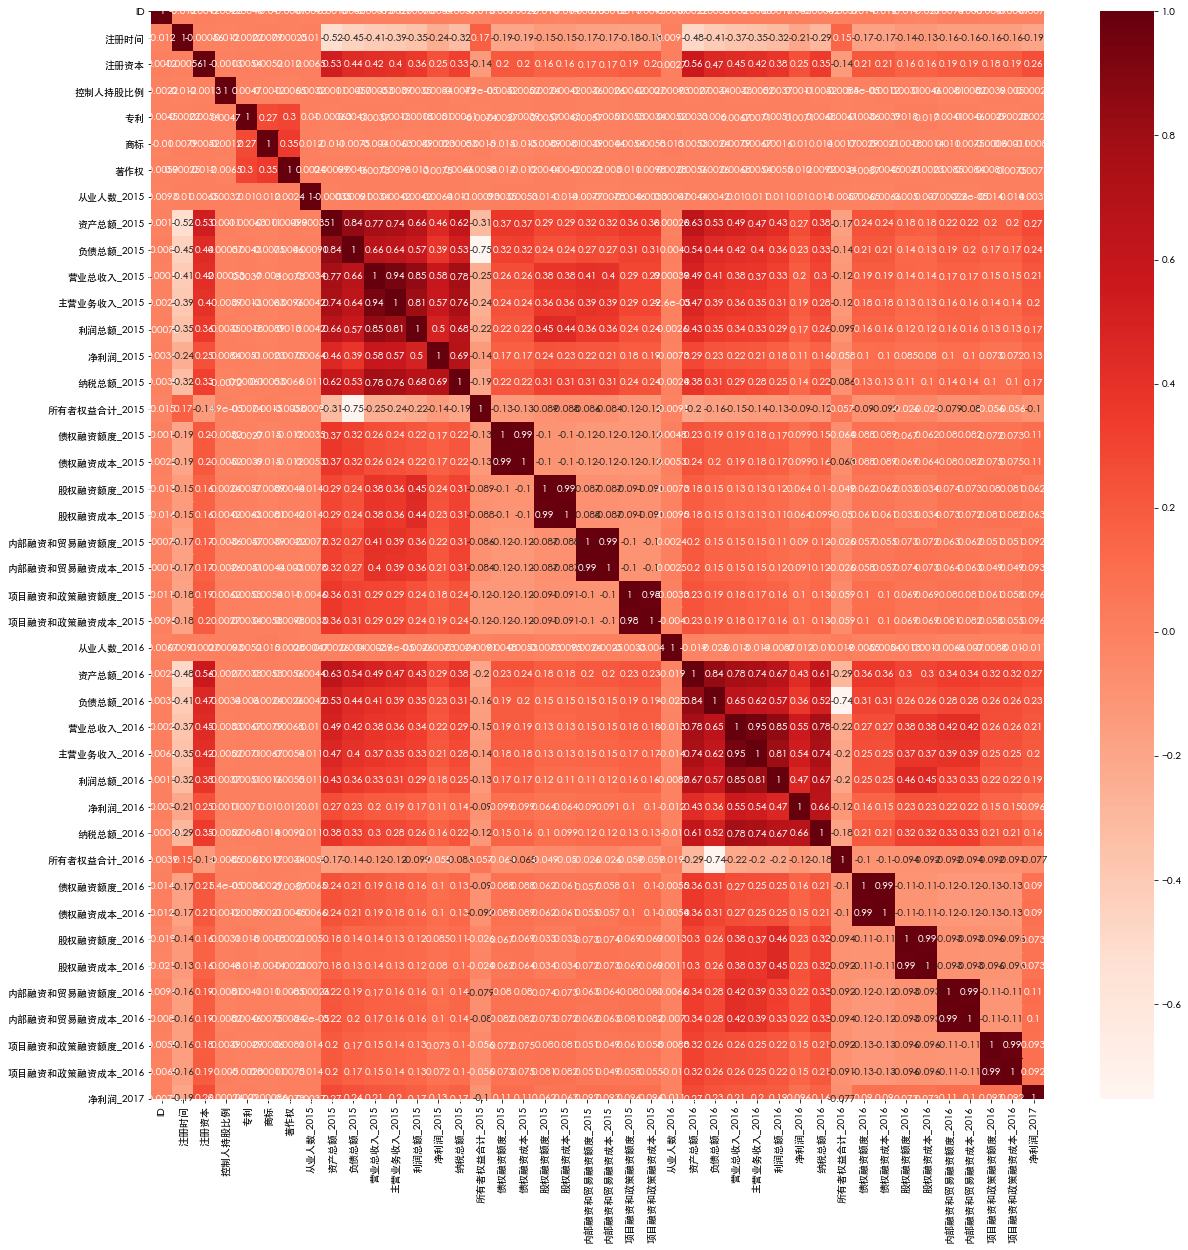

In [31]:
# Using Pearson Correlation
plt.figure(figsize=(20,20))
cor = full_train.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [32]:
# Correlation with output variable
cor_target = abs(cor["净利润_2017"])

# Selecting highly correlated features
relevant_features = cor_target[cor_target>0.2] # 相关性如此之低🤣
print(relevant_features)

注册资本           0.255361
资产总额_2015      0.274844
负债总额_2015      0.242863
营业总收入_2015     0.214984
主营业务收入_2015    0.204694
资产总额_2016      0.271162
负债总额_2016      0.228863
营业总收入_2016     0.212559
主营业务收入_2016    0.204853
净利润_2017       1.000000
Name: 净利润_2017, dtype: float64


##### 查看筛选出来的这些特征相关性高不高，如果两特征相关性高，则只取其中之一

In [33]:
print(full_train[["资产总额_2015", "负债总额_2015", "营业总收入_2015", "主营业务收入_2015"]].corr())
print(full_train[["资产总额_2016", "负债总额_2016", "营业总收入_2016", "主营业务收入_2016"]].corr())

             资产总额_2015  负债总额_2015  营业总收入_2015  主营业务收入_2015
资产总额_2015     1.000000   0.843874    0.774311     0.741586
负债总额_2015     0.843874   1.000000    0.661882     0.639355
营业总收入_2015    0.774311   0.661882    1.000000     0.944990
主营业务收入_2015   0.741586   0.639355    0.944990     1.000000
             资产总额_2016  负债总额_2016  营业总收入_2016  主营业务收入_2016
资产总额_2016     1.000000   0.838313    0.775047     0.742080
负债总额_2016     0.838313   1.000000    0.650716     0.619349
营业总收入_2016    0.775047   0.650716    1.000000     0.945295
主营业务收入_2016   0.742080   0.619349    0.945295     1.000000


##### 可以看出每年的主营业务收入和营业总收入，以及负债总额和资产总额的相关性很都高，可以只选其一

In [34]:
# train_X_6 = train_X[["ID", "资产总额_2015", "主营业务收入_2015", "资产总额_2016", "主营业务收入_2016"]]
# valid_X_6 = valid_X[["ID", "资产总额_2015", "主营业务收入_2015", "资产总额_2016", "主营业务收入_2016"]]
# test_X_6 = test[["ID", "资产总额_2015", "主营业务收入_2015", "资产总额_2016", "主营业务收入_2016"]]

In [35]:
train_X_6 = train_X[["营业总收入_2015", "负债总额_2015", "营业总收入_2016", "负债总额_2016"]]
valid_X_6 = valid_X[["营业总收入_2015", "负债总额_2015", "营业总收入_2016", "负债总额_2016"]]
test_X_6 = test[["营业总收入_2015", "负债总额_2015", "营业总收入_2016", "负债总额_2016"]]

In [36]:
# 模型训练和预测
_ = train_xgb(train_X_6, train_y, valid_X_6, valid_y, test_X_6, 'xgb_06') # 0.0385 比做了类别数据编码的效果好一丢丢

Mean Absolute Error(平均绝对误差): 0.0385
Mean Absolute Percentage Error(平均绝对百分比误差): 14.215499
Mean Squared Error(均方误差): 0.004226
Root Squared Error(均方根误差): 0.065011
r-2 score: 0.088135


In [37]:
# LightGBM
_ = train_gbm(train_X_6, train_y, valid_X_6, valid_y, test_X_6, 'gbm_06') # 0.041725 emmm 变大了。。

[1]	valid_0's l1: 0.0417291	valid_0's l2: 0.0046283	valid_0's auc: 1
Training until validation scores don't improve for 1000 rounds.
[2]	valid_0's l1: 0.0416766	valid_0's l2: 0.00462015	valid_0's auc: 1
[3]	valid_0's l1: 0.0416213	valid_0's l2: 0.00461246	valid_0's auc: 1
[4]	valid_0's l1: 0.0415653	valid_0's l2: 0.00460412	valid_0's auc: 1
[5]	valid_0's l1: 0.0415162	valid_0's l2: 0.00459652	valid_0's auc: 1
[6]	valid_0's l1: 0.0414709	valid_0's l2: 0.00459029	valid_0's auc: 1
[7]	valid_0's l1: 0.0414286	valid_0's l2: 0.00458441	valid_0's auc: 1
[8]	valid_0's l1: 0.0413828	valid_0's l2: 0.00457782	valid_0's auc: 1
[9]	valid_0's l1: 0.0413381	valid_0's l2: 0.00457147	valid_0's auc: 1
[10]	valid_0's l1: 0.0412951	valid_0's l2: 0.00456524	valid_0's auc: 1
[11]	valid_0's l1: 0.0412427	valid_0's l2: 0.00455871	valid_0's auc: 1
[12]	valid_0's l1: 0.0411924	valid_0's l2: 0.0045518	valid_0's auc: 1
[13]	valid_0's l1: 0.0411478	valid_0's l2: 0.0045461	valid_0's auc: 1
[14]	valid_0's l1: 0.0411

/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[27]	valid_0's l1: 0.040551	valid_0's l2: 0.00446895	valid_0's auc: 1
[28]	valid_0's l1: 0.0405177	valid_0's l2: 0.0044643	valid_0's auc: 1
[29]	valid_0's l1: 0.0404791	valid_0's l2: 0.0044595	valid_0's auc: 1
[30]	valid_0's l1: 0.0404434	valid_0's l2: 0.0044554	valid_0's auc: 1
[31]	valid_0's l1: 0.0404059	valid_0's l2: 0.00445029	valid_0's auc: 1
[32]	valid_0's l1: 0.0403681	valid_0's l2: 0.00444517	valid_0's auc: 1
[33]	valid_0's l1: 0.0403354	valid_0's l2: 0.00444095	valid_0's auc: 1
[34]	valid_0's l1: 0.0402971	valid_0's l2: 0.00443572	valid_0's auc: 1
[35]	valid_0's l1: 0.0402614	valid_0's l2: 0.00443099	valid_0's auc: 1
[36]	valid_0's l1: 0.0402248	valid_0's l2: 0.00442598	valid_0's auc: 1
[37]	valid_0's l1: 0.0401908	valid_0's l2: 0.00442169	valid_0's auc: 1
[38]	valid_0's l1: 0.0401625	valid_0's l2: 0.00441791	valid_0's auc: 1
[39]	valid_0's l1: 0.0401337	valid_0's l2: 0.00441422	valid_0's auc: 1
[40]	valid_0's l1: 0.0400988	valid_0's l2: 0.00440946	valid_0's auc: 1
[41]	valid

[189]	valid_0's l1: 0.0384916	valid_0's l2: 0.00425036	valid_0's auc: 1
[190]	valid_0's l1: 0.0384882	valid_0's l2: 0.00425051	valid_0's auc: 1
[191]	valid_0's l1: 0.0384852	valid_0's l2: 0.00425057	valid_0's auc: 1
[192]	valid_0's l1: 0.0384839	valid_0's l2: 0.00425012	valid_0's auc: 1
[193]	valid_0's l1: 0.0384822	valid_0's l2: 0.00424959	valid_0's auc: 1
[194]	valid_0's l1: 0.0384821	valid_0's l2: 0.00424923	valid_0's auc: 1
[195]	valid_0's l1: 0.0384806	valid_0's l2: 0.00424893	valid_0's auc: 1
[196]	valid_0's l1: 0.0384787	valid_0's l2: 0.00424864	valid_0's auc: 1
[197]	valid_0's l1: 0.0384761	valid_0's l2: 0.00424874	valid_0's auc: 1
[198]	valid_0's l1: 0.0384752	valid_0's l2: 0.00424803	valid_0's auc: 1
[199]	valid_0's l1: 0.0384719	valid_0's l2: 0.00424785	valid_0's auc: 1
[200]	valid_0's l1: 0.0384683	valid_0's l2: 0.00424768	valid_0's auc: 1
[201]	valid_0's l1: 0.0384672	valid_0's l2: 0.00424844	valid_0's auc: 1
[202]	valid_0's l1: 0.0384661	valid_0's l2: 0.00424913	valid_0's

[357]	valid_0's l1: 0.038358	valid_0's l2: 0.00426258	valid_0's auc: 1
[358]	valid_0's l1: 0.0383588	valid_0's l2: 0.00426272	valid_0's auc: 1
[359]	valid_0's l1: 0.0383584	valid_0's l2: 0.00426289	valid_0's auc: 1
[360]	valid_0's l1: 0.0383577	valid_0's l2: 0.00426287	valid_0's auc: 1
[361]	valid_0's l1: 0.0383569	valid_0's l2: 0.00426261	valid_0's auc: 1
[362]	valid_0's l1: 0.0383568	valid_0's l2: 0.00426306	valid_0's auc: 1
[363]	valid_0's l1: 0.0383544	valid_0's l2: 0.00426297	valid_0's auc: 1
[364]	valid_0's l1: 0.0383543	valid_0's l2: 0.00426344	valid_0's auc: 1
[365]	valid_0's l1: 0.0383536	valid_0's l2: 0.0042632	valid_0's auc: 1
[366]	valid_0's l1: 0.0383531	valid_0's l2: 0.00426297	valid_0's auc: 1
[367]	valid_0's l1: 0.0383529	valid_0's l2: 0.00426285	valid_0's auc: 1
[368]	valid_0's l1: 0.0383521	valid_0's l2: 0.00426252	valid_0's auc: 1
[369]	valid_0's l1: 0.0383519	valid_0's l2: 0.00426242	valid_0's auc: 1
[370]	valid_0's l1: 0.0383494	valid_0's l2: 0.00426236	valid_0's a

[511]	valid_0's l1: 0.0383979	valid_0's l2: 0.00428189	valid_0's auc: 1
[512]	valid_0's l1: 0.0384025	valid_0's l2: 0.00428229	valid_0's auc: 1
[513]	valid_0's l1: 0.038405	valid_0's l2: 0.00428229	valid_0's auc: 1
[514]	valid_0's l1: 0.0384078	valid_0's l2: 0.00428244	valid_0's auc: 1
[515]	valid_0's l1: 0.0384122	valid_0's l2: 0.00428253	valid_0's auc: 1
[516]	valid_0's l1: 0.0384171	valid_0's l2: 0.00428306	valid_0's auc: 1
[517]	valid_0's l1: 0.0384193	valid_0's l2: 0.00428303	valid_0's auc: 1
[518]	valid_0's l1: 0.0384226	valid_0's l2: 0.00428321	valid_0's auc: 1
[519]	valid_0's l1: 0.0384255	valid_0's l2: 0.00428352	valid_0's auc: 1
[520]	valid_0's l1: 0.0384295	valid_0's l2: 0.00428363	valid_0's auc: 1
[521]	valid_0's l1: 0.0384294	valid_0's l2: 0.00428401	valid_0's auc: 1
[522]	valid_0's l1: 0.038432	valid_0's l2: 0.00428445	valid_0's auc: 1
[523]	valid_0's l1: 0.0384286	valid_0's l2: 0.00428432	valid_0's auc: 1
[524]	valid_0's l1: 0.0384251	valid_0's l2: 0.00428411	valid_0's a

[666]	valid_0's l1: 0.0384974	valid_0's l2: 0.0042962	valid_0's auc: 1
[667]	valid_0's l1: 0.0384952	valid_0's l2: 0.00429631	valid_0's auc: 1
[668]	valid_0's l1: 0.0384927	valid_0's l2: 0.00429631	valid_0's auc: 1
[669]	valid_0's l1: 0.0384939	valid_0's l2: 0.00429715	valid_0's auc: 1
[670]	valid_0's l1: 0.0384927	valid_0's l2: 0.00429713	valid_0's auc: 1
[671]	valid_0's l1: 0.0384951	valid_0's l2: 0.00429742	valid_0's auc: 1
[672]	valid_0's l1: 0.0384941	valid_0's l2: 0.00429701	valid_0's auc: 1
[673]	valid_0's l1: 0.038494	valid_0's l2: 0.0042967	valid_0's auc: 1
[674]	valid_0's l1: 0.0384946	valid_0's l2: 0.00429699	valid_0's auc: 1
[675]	valid_0's l1: 0.0384948	valid_0's l2: 0.00429693	valid_0's auc: 1
[676]	valid_0's l1: 0.0384954	valid_0's l2: 0.00429723	valid_0's auc: 1
[677]	valid_0's l1: 0.0384961	valid_0's l2: 0.00429713	valid_0's auc: 1
[678]	valid_0's l1: 0.0384985	valid_0's l2: 0.00429732	valid_0's auc: 1
[679]	valid_0's l1: 0.0384985	valid_0's l2: 0.00429704	valid_0's au

[806]	valid_0's l1: 0.0385698	valid_0's l2: 0.00431765	valid_0's auc: 1
[807]	valid_0's l1: 0.0385694	valid_0's l2: 0.00431789	valid_0's auc: 1
[808]	valid_0's l1: 0.0385704	valid_0's l2: 0.00431794	valid_0's auc: 1
[809]	valid_0's l1: 0.03857	valid_0's l2: 0.0043182	valid_0's auc: 1
[810]	valid_0's l1: 0.0385715	valid_0's l2: 0.00431869	valid_0's auc: 1
[811]	valid_0's l1: 0.0385721	valid_0's l2: 0.00431863	valid_0's auc: 1
[812]	valid_0's l1: 0.0385738	valid_0's l2: 0.00431882	valid_0's auc: 1
[813]	valid_0's l1: 0.0385755	valid_0's l2: 0.00431903	valid_0's auc: 1
[814]	valid_0's l1: 0.0385772	valid_0's l2: 0.00431917	valid_0's auc: 1
[815]	valid_0's l1: 0.0385773	valid_0's l2: 0.00431922	valid_0's auc: 1
[816]	valid_0's l1: 0.0385777	valid_0's l2: 0.00431931	valid_0's auc: 1
[817]	valid_0's l1: 0.0385789	valid_0's l2: 0.0043195	valid_0's auc: 1
[818]	valid_0's l1: 0.0385786	valid_0's l2: 0.00431942	valid_0's auc: 1
[819]	valid_0's l1: 0.0385782	valid_0's l2: 0.00431908	valid_0's auc

[932]	valid_0's l1: 0.0386001	valid_0's l2: 0.00433418	valid_0's auc: 1
[933]	valid_0's l1: 0.0386005	valid_0's l2: 0.00433425	valid_0's auc: 1
[934]	valid_0's l1: 0.038601	valid_0's l2: 0.00433434	valid_0's auc: 1
[935]	valid_0's l1: 0.0386005	valid_0's l2: 0.00433428	valid_0's auc: 1
[936]	valid_0's l1: 0.0386028	valid_0's l2: 0.00433489	valid_0's auc: 1
[937]	valid_0's l1: 0.0386051	valid_0's l2: 0.00433551	valid_0's auc: 1
[938]	valid_0's l1: 0.0386045	valid_0's l2: 0.00433522	valid_0's auc: 1
[939]	valid_0's l1: 0.0386069	valid_0's l2: 0.00433584	valid_0's auc: 1
[940]	valid_0's l1: 0.0386085	valid_0's l2: 0.00433598	valid_0's auc: 1
[941]	valid_0's l1: 0.0386072	valid_0's l2: 0.00433552	valid_0's auc: 1
[942]	valid_0's l1: 0.0386086	valid_0's l2: 0.00433596	valid_0's auc: 1
[943]	valid_0's l1: 0.0386082	valid_0's l2: 0.00433571	valid_0's auc: 1
[944]	valid_0's l1: 0.0386081	valid_0's l2: 0.00433548	valid_0's auc: 1
[945]	valid_0's l1: 0.0386069	valid_0's l2: 0.00433519	valid_0's 

In [38]:
# Linear Regression
_ = train_lr(train_X_6, train_y, valid_X_6, valid_y, test_X_6, 'lr_06') # 0.03807 目前最佳

Mean Absolute Error(平均绝对误差): 0.038521
Mean Absolute Percentage Error(平均绝对百分比误差): 14.207741
Mean Squared Error(均方误差): 0.004216
Root Squared Error(均方根误差): 0.064931
r-2 score: 0.0904


#### sklearn - Removing features with low variance

In [39]:
from sklearn.feature_selection import VarianceThreshold

In [40]:
train_X_7 = train_X[train_X.columns.drop(["行业", "区域", "企业类型", "控制人类型"])]
valid_X_7 = valid_X[valid_X.columns.drop(["行业", "区域", "企业类型", "控制人类型"])]
test_X_7 = test[test.columns.drop(["行业", "区域", "企业类型", "控制人类型"])]
print(train_X_7.shape)

sel = VarianceThreshold(threshold=(.5 * (1 - .5)))
train_X_7 = sel.fit_transform(train_X_7)
valid_X_7 = sel.fit_transform(valid_X_7)
test_X_7 = sel.fit_transform(test_X_7)
print(train_X_7.shape, valid_X_7.shape, test_X_7.shape)

(12988, 41)
(12988, 37) (4330, 37) (4068, 37)


In [41]:
_ = train_xgb(train_X_7, train_y, valid_X_7, valid_y, test_X_7, 'xgb_07') # 0.03851 目前还不错的分数

Mean Absolute Error(平均绝对误差): 0.03851
Mean Absolute Percentage Error(平均绝对百分比误差): 14.401854
Mean Squared Error(均方误差): 0.004208
Root Squared Error(均方根误差): 0.06487
r-2 score: 0.092096


In [42]:
# LightGBM
_ = train_gbm(train_X_7, train_y, valid_X_7, valid_y, test_X_7, 'gbm_07') # 0.04172 

[1]	valid_0's l1: 0.0417203	valid_0's l2: 0.00462667	valid_0's auc: 1
Training until validation scores don't improve for 1000 rounds.
[2]	valid_0's l1: 0.041654	valid_0's l2: 0.0046158	valid_0's auc: 1
[3]	valid_0's l1: 0.0415861	valid_0's l2: 0.00460473	valid_0's auc: 1


/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[4]	valid_0's l1: 0.0415234	valid_0's l2: 0.00459567	valid_0's auc: 1
[5]	valid_0's l1: 0.0414567	valid_0's l2: 0.00458604	valid_0's auc: 1
[6]	valid_0's l1: 0.0413925	valid_0's l2: 0.00457664	valid_0's auc: 1
[7]	valid_0's l1: 0.0413296	valid_0's l2: 0.0045664	valid_0's auc: 1
[8]	valid_0's l1: 0.041269	valid_0's l2: 0.00455796	valid_0's auc: 1
[9]	valid_0's l1: 0.0412109	valid_0's l2: 0.00454948	valid_0's auc: 1
[10]	valid_0's l1: 0.0411528	valid_0's l2: 0.00454036	valid_0's auc: 1
[11]	valid_0's l1: 0.0410983	valid_0's l2: 0.00453231	valid_0's auc: 1
[12]	valid_0's l1: 0.0410446	valid_0's l2: 0.00452469	valid_0's auc: 1
[13]	valid_0's l1: 0.0409985	valid_0's l2: 0.00451831	valid_0's auc: 1
[14]	valid_0's l1: 0.0409431	valid_0's l2: 0.0045107	valid_0's auc: 1
[15]	valid_0's l1: 0.0408918	valid_0's l2: 0.00450353	valid_0's auc: 1
[16]	valid_0's l1: 0.040837	valid_0's l2: 0.00449588	valid_0's auc: 1
[17]	valid_0's l1: 0.0407822	valid_0's l2: 0.00448883	valid_0's auc: 1
[18]	valid_0's l

[123]	valid_0's l1: 0.0382569	valid_0's l2: 0.00419261	valid_0's auc: 1
[124]	valid_0's l1: 0.0382504	valid_0's l2: 0.00419156	valid_0's auc: 1
[125]	valid_0's l1: 0.0382434	valid_0's l2: 0.00419024	valid_0's auc: 1
[126]	valid_0's l1: 0.0382388	valid_0's l2: 0.00418963	valid_0's auc: 1
[127]	valid_0's l1: 0.0382304	valid_0's l2: 0.00418867	valid_0's auc: 1
[128]	valid_0's l1: 0.038219	valid_0's l2: 0.00418813	valid_0's auc: 1
[129]	valid_0's l1: 0.0382062	valid_0's l2: 0.00418723	valid_0's auc: 1
[130]	valid_0's l1: 0.0381963	valid_0's l2: 0.00418621	valid_0's auc: 1
[131]	valid_0's l1: 0.0381915	valid_0's l2: 0.0041856	valid_0's auc: 1
[132]	valid_0's l1: 0.0381882	valid_0's l2: 0.00418512	valid_0's auc: 1
[133]	valid_0's l1: 0.0381843	valid_0's l2: 0.00418452	valid_0's auc: 1
[134]	valid_0's l1: 0.038182	valid_0's l2: 0.00418404	valid_0's auc: 1
[135]	valid_0's l1: 0.0381747	valid_0's l2: 0.00418344	valid_0's auc: 1
[136]	valid_0's l1: 0.0381701	valid_0's l2: 0.00418321	valid_0's au

[247]	valid_0's l1: 0.0378654	valid_0's l2: 0.00417807	valid_0's auc: 1
[248]	valid_0's l1: 0.0378638	valid_0's l2: 0.00417713	valid_0's auc: 1
[249]	valid_0's l1: 0.0378637	valid_0's l2: 0.00417761	valid_0's auc: 1
[250]	valid_0's l1: 0.0378671	valid_0's l2: 0.00417835	valid_0's auc: 1
[251]	valid_0's l1: 0.0378639	valid_0's l2: 0.00417805	valid_0's auc: 1
[252]	valid_0's l1: 0.0378628	valid_0's l2: 0.00417825	valid_0's auc: 1
[253]	valid_0's l1: 0.0378598	valid_0's l2: 0.00417813	valid_0's auc: 1
[254]	valid_0's l1: 0.0378563	valid_0's l2: 0.00417757	valid_0's auc: 1
[255]	valid_0's l1: 0.0378543	valid_0's l2: 0.00417747	valid_0's auc: 1
[256]	valid_0's l1: 0.0378532	valid_0's l2: 0.00417754	valid_0's auc: 1
[257]	valid_0's l1: 0.0378505	valid_0's l2: 0.00417727	valid_0's auc: 1
[258]	valid_0's l1: 0.0378507	valid_0's l2: 0.00417771	valid_0's auc: 1
[259]	valid_0's l1: 0.0378475	valid_0's l2: 0.00417725	valid_0's auc: 1
[260]	valid_0's l1: 0.0378477	valid_0's l2: 0.00417734	valid_0's

[392]	valid_0's l1: 0.0377819	valid_0's l2: 0.00417297	valid_0's auc: 1
[393]	valid_0's l1: 0.0377839	valid_0's l2: 0.00417293	valid_0's auc: 1
[394]	valid_0's l1: 0.0377864	valid_0's l2: 0.00417302	valid_0's auc: 1
[395]	valid_0's l1: 0.0377877	valid_0's l2: 0.00417309	valid_0's auc: 1
[396]	valid_0's l1: 0.03779	valid_0's l2: 0.00417312	valid_0's auc: 1
[397]	valid_0's l1: 0.0377911	valid_0's l2: 0.00417315	valid_0's auc: 1
[398]	valid_0's l1: 0.0377925	valid_0's l2: 0.0041736	valid_0's auc: 1
[399]	valid_0's l1: 0.037794	valid_0's l2: 0.00417347	valid_0's auc: 1
[400]	valid_0's l1: 0.0377989	valid_0's l2: 0.00417391	valid_0's auc: 1
[401]	valid_0's l1: 0.0377994	valid_0's l2: 0.00417392	valid_0's auc: 1
[402]	valid_0's l1: 0.0378006	valid_0's l2: 0.0041743	valid_0's auc: 1
[403]	valid_0's l1: 0.0377997	valid_0's l2: 0.00417397	valid_0's auc: 1
[404]	valid_0's l1: 0.0377971	valid_0's l2: 0.00417313	valid_0's auc: 1
[405]	valid_0's l1: 0.0377942	valid_0's l2: 0.00417276	valid_0's auc:

[537]	valid_0's l1: 0.0379135	valid_0's l2: 0.00418827	valid_0's auc: 1
[538]	valid_0's l1: 0.0379147	valid_0's l2: 0.00418861	valid_0's auc: 1
[539]	valid_0's l1: 0.0379145	valid_0's l2: 0.00418807	valid_0's auc: 1
[540]	valid_0's l1: 0.0379136	valid_0's l2: 0.00418824	valid_0's auc: 1
[541]	valid_0's l1: 0.0379116	valid_0's l2: 0.00418773	valid_0's auc: 1
[542]	valid_0's l1: 0.037912	valid_0's l2: 0.00418785	valid_0's auc: 1
[543]	valid_0's l1: 0.0379125	valid_0's l2: 0.00418791	valid_0's auc: 1
[544]	valid_0's l1: 0.0379133	valid_0's l2: 0.00418812	valid_0's auc: 1
[545]	valid_0's l1: 0.0379144	valid_0's l2: 0.00418884	valid_0's auc: 1
[546]	valid_0's l1: 0.0379162	valid_0's l2: 0.00418902	valid_0's auc: 1
[547]	valid_0's l1: 0.0379169	valid_0's l2: 0.00418919	valid_0's auc: 1
[548]	valid_0's l1: 0.0379174	valid_0's l2: 0.00418935	valid_0's auc: 1
[549]	valid_0's l1: 0.0379183	valid_0's l2: 0.00418968	valid_0's auc: 1
[550]	valid_0's l1: 0.0379169	valid_0's l2: 0.00419007	valid_0's 

[661]	valid_0's l1: 0.0379254	valid_0's l2: 0.00420045	valid_0's auc: 1
[662]	valid_0's l1: 0.0379238	valid_0's l2: 0.00420038	valid_0's auc: 1
[663]	valid_0's l1: 0.0379226	valid_0's l2: 0.00420043	valid_0's auc: 1
[664]	valid_0's l1: 0.0379213	valid_0's l2: 0.00420086	valid_0's auc: 1
[665]	valid_0's l1: 0.0379217	valid_0's l2: 0.00420125	valid_0's auc: 1
[666]	valid_0's l1: 0.0379201	valid_0's l2: 0.00420118	valid_0's auc: 1
[667]	valid_0's l1: 0.0379186	valid_0's l2: 0.00420139	valid_0's auc: 1
[668]	valid_0's l1: 0.0379164	valid_0's l2: 0.00420158	valid_0's auc: 1
[669]	valid_0's l1: 0.0379158	valid_0's l2: 0.00420171	valid_0's auc: 1
[670]	valid_0's l1: 0.0379143	valid_0's l2: 0.00420228	valid_0's auc: 1
[671]	valid_0's l1: 0.0379196	valid_0's l2: 0.00420305	valid_0's auc: 1
[672]	valid_0's l1: 0.0379257	valid_0's l2: 0.00420405	valid_0's auc: 1
[673]	valid_0's l1: 0.0379279	valid_0's l2: 0.00420474	valid_0's auc: 1
[674]	valid_0's l1: 0.0379304	valid_0's l2: 0.00420522	valid_0's

[777]	valid_0's l1: 0.0379561	valid_0's l2: 0.00420958	valid_0's auc: 1
[778]	valid_0's l1: 0.0379566	valid_0's l2: 0.00421007	valid_0's auc: 1
[779]	valid_0's l1: 0.0379587	valid_0's l2: 0.00421041	valid_0's auc: 1
[780]	valid_0's l1: 0.0379594	valid_0's l2: 0.00421026	valid_0's auc: 1
[781]	valid_0's l1: 0.0379553	valid_0's l2: 0.00420984	valid_0's auc: 1
[782]	valid_0's l1: 0.0379544	valid_0's l2: 0.00421014	valid_0's auc: 1
[783]	valid_0's l1: 0.0379546	valid_0's l2: 0.00421036	valid_0's auc: 1
[784]	valid_0's l1: 0.0379555	valid_0's l2: 0.00421105	valid_0's auc: 1
[785]	valid_0's l1: 0.0379535	valid_0's l2: 0.00421094	valid_0's auc: 1
[786]	valid_0's l1: 0.0379497	valid_0's l2: 0.00421053	valid_0's auc: 1
[787]	valid_0's l1: 0.0379484	valid_0's l2: 0.00421073	valid_0's auc: 1
[788]	valid_0's l1: 0.0379473	valid_0's l2: 0.00421114	valid_0's auc: 1
[789]	valid_0's l1: 0.0379473	valid_0's l2: 0.00421164	valid_0's auc: 1
[790]	valid_0's l1: 0.0379473	valid_0's l2: 0.00421198	valid_0's

[909]	valid_0's l1: 0.0380079	valid_0's l2: 0.00423864	valid_0's auc: 1
[910]	valid_0's l1: 0.0380068	valid_0's l2: 0.00423833	valid_0's auc: 1
[911]	valid_0's l1: 0.0380078	valid_0's l2: 0.0042381	valid_0's auc: 1
[912]	valid_0's l1: 0.0380093	valid_0's l2: 0.00423805	valid_0's auc: 1
[913]	valid_0's l1: 0.0380108	valid_0's l2: 0.0042381	valid_0's auc: 1
[914]	valid_0's l1: 0.0380106	valid_0's l2: 0.00423803	valid_0's auc: 1
[915]	valid_0's l1: 0.038012	valid_0's l2: 0.00423803	valid_0's auc: 1
[916]	valid_0's l1: 0.0380146	valid_0's l2: 0.00423824	valid_0's auc: 1
[917]	valid_0's l1: 0.0380163	valid_0's l2: 0.00423815	valid_0's auc: 1
[918]	valid_0's l1: 0.0380178	valid_0's l2: 0.00423828	valid_0's auc: 1
[919]	valid_0's l1: 0.03802	valid_0's l2: 0.00423842	valid_0's auc: 1
[920]	valid_0's l1: 0.0380209	valid_0's l2: 0.00423834	valid_0's auc: 1
[921]	valid_0's l1: 0.038023	valid_0's l2: 0.0042389	valid_0's auc: 1
[922]	valid_0's l1: 0.0380234	valid_0's l2: 0.00423917	valid_0's auc: 1

In [43]:
# Linear Regression
_ = train_lr(train_X_7, train_y, valid_X_7, valid_y, test_X_7, 'lr_07') # 0.038278 emmm 反弹了？

Mean Absolute Error(平均绝对误差): 0.038278
Mean Absolute Percentage Error(平均绝对百分比误差): 14.252323
Mean Squared Error(均方误差): 0.004162
Root Squared Error(均方根误差): 0.064516
r-2 score: 0.101969


#### Backward Elimination

首先将所有可能的特征提供给模型，然后检查模型的性能，迭代地删除性能最差的特征，直到模型的整体性能在可接受的范围内。此处用于评估要素性能的性能指标为**pvalue**，如果p值大于0.05，则将其删除，否则将其保留。

使用OLS模型，代表“普通最小二乘”，该模型用于执行线性回归。

In [44]:
train_X_8 = train_X[train_X.columns.drop(["行业", "区域", "企业类型", "控制人类型"])]
valid_X_8 = valid_X[valid_X.columns.drop(["行业", "区域", "企业类型", "控制人类型"])]
test_X_8 = test[test.columns.drop(["行业", "区域", "企业类型", "控制人类型"])]

In [45]:
# Backward Elimination
cols = list(train_X_8.columns)
pmax = 1
while (len(cols)>0):
    p = []
    train_X_8_1 = train_X_8[cols]
    train_X_8_1 = sm.add_constant(train_X_8_1)
    model = sm.OLS(train_y, train_X_8_1).fit()
    p = pd.Series(model.pvalues.values[1:], index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    
    if(pmax > 0.05):
        cols.remove(feature_with_p_max)
    else:
        break
selected_features_BE = cols

print(selected_features_BE)

['注册时间', '注册资本', '负债总额_2015', '所有者权益合计_2015', '股权融资成本_2015', '负债总额_2016', '营业总收入_2016', '主营业务收入_2016', '净利润_2016', '所有者权益合计_2016', '内部融资和贸易融资额度_2016', '内部融资和贸易融资成本_2016']


In [46]:
train_X_8 = train_X_8[['注册时间', '注册资本', '负债总额_2015', '所有者权益合计_2015', '股权融资成本_2015', '负债总额_2016', '营业总收入_2016', '主营业务收入_2016', '净利润_2016', '所有者权益合计_2016', '内部融资和贸易融资额度_2016', '内部融资和贸易融资成本_2016']]
valid_X_8 = valid_X_8[['注册时间', '注册资本', '负债总额_2015', '所有者权益合计_2015', '股权融资成本_2015', '负债总额_2016', '营业总收入_2016', '主营业务收入_2016', '净利润_2016', '所有者权益合计_2016', '内部融资和贸易融资额度_2016', '内部融资和贸易融资成本_2016']]
test_X_8 = test[['注册时间', '注册资本', '负债总额_2015', '所有者权益合计_2015', '股权融资成本_2015', '负债总额_2016', '营业总收入_2016', '主营业务收入_2016', '净利润_2016', '所有者权益合计_2016', '内部融资和贸易融资额度_2016', '内部融资和贸易融资成本_2016']]

In [47]:
_ = train_xgb(train_X_8, train_y, valid_X_8, valid_y, test_X_8, 'xgb_08') # 0.038638 

Mean Absolute Error(平均绝对误差): 0.038638
Mean Absolute Percentage Error(平均绝对百分比误差): 14.472337
Mean Squared Error(均方误差): 0.004172
Root Squared Error(均方根误差): 0.064594
r-2 score: 0.099798


In [48]:
# LightGBM
_ = train_gbm(train_X_8, train_y, valid_X_8, valid_y, test_X_8, 'gbm_08') # 0.041719 

[1]	valid_0's l1: 0.041719	valid_0's l2: 0.00462669	valid_0's auc: 1
Training until validation scores don't improve for 1000 rounds.
[2]	valid_0's l1: 0.0416554	valid_0's l2: 0.00461587	valid_0's auc: 1
[3]	valid_0's l1: 0.0415934	valid_0's l2: 0.00460509	valid_0's auc: 1
[4]	valid_0's l1: 0.0415334	valid_0's l2: 0.00459528	valid_0's auc: 1
[5]	valid_0's l1: 0.0414759	valid_0's l2: 0.00458721	valid_0's auc: 1
[6]	valid_0's l1: 0.0414174	valid_0's l2: 0.00457738	valid_0's auc: 1


/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[7]	valid_0's l1: 0.0413621	valid_0's l2: 0.00456999	valid_0's auc: 1
[8]	valid_0's l1: 0.0413079	valid_0's l2: 0.00456001	valid_0's auc: 1
[9]	valid_0's l1: 0.0412568	valid_0's l2: 0.00455301	valid_0's auc: 1
[10]	valid_0's l1: 0.041204	valid_0's l2: 0.00454426	valid_0's auc: 1
[11]	valid_0's l1: 0.0411458	valid_0's l2: 0.00453674	valid_0's auc: 1
[12]	valid_0's l1: 0.0410831	valid_0's l2: 0.0045276	valid_0's auc: 1
[13]	valid_0's l1: 0.041022	valid_0's l2: 0.00451777	valid_0's auc: 1
[14]	valid_0's l1: 0.040961	valid_0's l2: 0.00450902	valid_0's auc: 1
[15]	valid_0's l1: 0.0409026	valid_0's l2: 0.00450057	valid_0's auc: 1
[16]	valid_0's l1: 0.0408464	valid_0's l2: 0.0044924	valid_0's auc: 1
[17]	valid_0's l1: 0.0407916	valid_0's l2: 0.00448418	valid_0's auc: 1
[18]	valid_0's l1: 0.0407366	valid_0's l2: 0.00447632	valid_0's auc: 1
[19]	valid_0's l1: 0.0406972	valid_0's l2: 0.00447074	valid_0's auc: 1
[20]	valid_0's l1: 0.0406477	valid_0's l2: 0.00446449	valid_0's auc: 1
[21]	valid_0's

[123]	valid_0's l1: 0.0382211	valid_0's l2: 0.00415929	valid_0's auc: 1
[124]	valid_0's l1: 0.0382166	valid_0's l2: 0.0041602	valid_0's auc: 1
[125]	valid_0's l1: 0.0382109	valid_0's l2: 0.00416042	valid_0's auc: 1
[126]	valid_0's l1: 0.0382037	valid_0's l2: 0.00415983	valid_0's auc: 1
[127]	valid_0's l1: 0.0381935	valid_0's l2: 0.00415914	valid_0's auc: 1
[128]	valid_0's l1: 0.0381859	valid_0's l2: 0.00415861	valid_0's auc: 1
[129]	valid_0's l1: 0.0381743	valid_0's l2: 0.00415775	valid_0's auc: 1
[130]	valid_0's l1: 0.0381594	valid_0's l2: 0.00415636	valid_0's auc: 1
[131]	valid_0's l1: 0.0381492	valid_0's l2: 0.004156	valid_0's auc: 1
[132]	valid_0's l1: 0.0381409	valid_0's l2: 0.0041557	valid_0's auc: 1
[133]	valid_0's l1: 0.0381336	valid_0's l2: 0.00415561	valid_0's auc: 1
[134]	valid_0's l1: 0.0381276	valid_0's l2: 0.00415507	valid_0's auc: 1
[135]	valid_0's l1: 0.0381198	valid_0's l2: 0.00415482	valid_0's auc: 1
[136]	valid_0's l1: 0.0381139	valid_0's l2: 0.00415426	valid_0's auc

[287]	valid_0's l1: 0.0378472	valid_0's l2: 0.00417034	valid_0's auc: 1
[288]	valid_0's l1: 0.0378473	valid_0's l2: 0.00417009	valid_0's auc: 1
[289]	valid_0's l1: 0.0378473	valid_0's l2: 0.00417112	valid_0's auc: 1
[290]	valid_0's l1: 0.0378436	valid_0's l2: 0.00417096	valid_0's auc: 1
[291]	valid_0's l1: 0.0378433	valid_0's l2: 0.00417105	valid_0's auc: 1
[292]	valid_0's l1: 0.0378431	valid_0's l2: 0.00417116	valid_0's auc: 1
[293]	valid_0's l1: 0.0378394	valid_0's l2: 0.00417047	valid_0's auc: 1
[294]	valid_0's l1: 0.0378381	valid_0's l2: 0.00417045	valid_0's auc: 1
[295]	valid_0's l1: 0.037837	valid_0's l2: 0.00417058	valid_0's auc: 1
[296]	valid_0's l1: 0.0378346	valid_0's l2: 0.00417048	valid_0's auc: 1
[297]	valid_0's l1: 0.0378329	valid_0's l2: 0.00417057	valid_0's auc: 1
[298]	valid_0's l1: 0.0378299	valid_0's l2: 0.00417046	valid_0's auc: 1
[299]	valid_0's l1: 0.0378268	valid_0's l2: 0.00417035	valid_0's auc: 1
[300]	valid_0's l1: 0.037824	valid_0's l2: 0.0041702	valid_0's au

[429]	valid_0's l1: 0.0378631	valid_0's l2: 0.00420429	valid_0's auc: 1
[430]	valid_0's l1: 0.0378637	valid_0's l2: 0.00420425	valid_0's auc: 1
[431]	valid_0's l1: 0.0378631	valid_0's l2: 0.00420455	valid_0's auc: 1
[432]	valid_0's l1: 0.0378639	valid_0's l2: 0.00420457	valid_0's auc: 1
[433]	valid_0's l1: 0.0378647	valid_0's l2: 0.00420461	valid_0's auc: 1
[434]	valid_0's l1: 0.0378662	valid_0's l2: 0.00420518	valid_0's auc: 1
[435]	valid_0's l1: 0.0378664	valid_0's l2: 0.00420531	valid_0's auc: 1
[436]	valid_0's l1: 0.0378671	valid_0's l2: 0.00420582	valid_0's auc: 1
[437]	valid_0's l1: 0.0378662	valid_0's l2: 0.00420591	valid_0's auc: 1
[438]	valid_0's l1: 0.0378655	valid_0's l2: 0.00420637	valid_0's auc: 1
[439]	valid_0's l1: 0.0378673	valid_0's l2: 0.004207	valid_0's auc: 1
[440]	valid_0's l1: 0.0378659	valid_0's l2: 0.00420712	valid_0's auc: 1
[441]	valid_0's l1: 0.0378673	valid_0's l2: 0.00420758	valid_0's auc: 1
[442]	valid_0's l1: 0.0378675	valid_0's l2: 0.00420813	valid_0's a

[556]	valid_0's l1: 0.0379826	valid_0's l2: 0.00423277	valid_0's auc: 1
[557]	valid_0's l1: 0.0379829	valid_0's l2: 0.004233	valid_0's auc: 1
[558]	valid_0's l1: 0.0379828	valid_0's l2: 0.00423312	valid_0's auc: 1
[559]	valid_0's l1: 0.0379827	valid_0's l2: 0.00423315	valid_0's auc: 1
[560]	valid_0's l1: 0.0379837	valid_0's l2: 0.00423326	valid_0's auc: 1
[561]	valid_0's l1: 0.0379816	valid_0's l2: 0.00423329	valid_0's auc: 1
[562]	valid_0's l1: 0.0379823	valid_0's l2: 0.00423336	valid_0's auc: 1
[563]	valid_0's l1: 0.0379823	valid_0's l2: 0.00423332	valid_0's auc: 1
[564]	valid_0's l1: 0.0379817	valid_0's l2: 0.00423383	valid_0's auc: 1
[565]	valid_0's l1: 0.0379796	valid_0's l2: 0.00423337	valid_0's auc: 1
[566]	valid_0's l1: 0.0379782	valid_0's l2: 0.00423341	valid_0's auc: 1
[567]	valid_0's l1: 0.03798	valid_0's l2: 0.00423383	valid_0's auc: 1
[568]	valid_0's l1: 0.0379804	valid_0's l2: 0.00423377	valid_0's auc: 1
[569]	valid_0's l1: 0.0379816	valid_0's l2: 0.00423383	valid_0's auc

[671]	valid_0's l1: 0.0380621	valid_0's l2: 0.0042588	valid_0's auc: 1
[672]	valid_0's l1: 0.0380638	valid_0's l2: 0.00425959	valid_0's auc: 1
[673]	valid_0's l1: 0.0380657	valid_0's l2: 0.00426042	valid_0's auc: 1
[674]	valid_0's l1: 0.0380678	valid_0's l2: 0.00426108	valid_0's auc: 1
[675]	valid_0's l1: 0.0380683	valid_0's l2: 0.0042611	valid_0's auc: 1
[676]	valid_0's l1: 0.0380705	valid_0's l2: 0.00426197	valid_0's auc: 1
[677]	valid_0's l1: 0.0380712	valid_0's l2: 0.00426252	valid_0's auc: 1
[678]	valid_0's l1: 0.0380692	valid_0's l2: 0.00426288	valid_0's auc: 1
[679]	valid_0's l1: 0.0380671	valid_0's l2: 0.00426322	valid_0's auc: 1
[680]	valid_0's l1: 0.0380694	valid_0's l2: 0.00426428	valid_0's auc: 1
[681]	valid_0's l1: 0.0380683	valid_0's l2: 0.00426402	valid_0's auc: 1
[682]	valid_0's l1: 0.0380673	valid_0's l2: 0.00426387	valid_0's auc: 1
[683]	valid_0's l1: 0.0380662	valid_0's l2: 0.00426373	valid_0's auc: 1
[684]	valid_0's l1: 0.0380648	valid_0's l2: 0.00426357	valid_0's a

[796]	valid_0's l1: 0.0381359	valid_0's l2: 0.00428518	valid_0's auc: 1
[797]	valid_0's l1: 0.0381365	valid_0's l2: 0.00428475	valid_0's auc: 1
[798]	valid_0's l1: 0.0381352	valid_0's l2: 0.00428492	valid_0's auc: 1
[799]	valid_0's l1: 0.0381366	valid_0's l2: 0.0042853	valid_0's auc: 1
[800]	valid_0's l1: 0.0381371	valid_0's l2: 0.00428535	valid_0's auc: 1
[801]	valid_0's l1: 0.0381379	valid_0's l2: 0.00428552	valid_0's auc: 1
[802]	valid_0's l1: 0.0381408	valid_0's l2: 0.00428616	valid_0's auc: 1
[803]	valid_0's l1: 0.0381411	valid_0's l2: 0.00428615	valid_0's auc: 1
[804]	valid_0's l1: 0.0381415	valid_0's l2: 0.00428594	valid_0's auc: 1
[805]	valid_0's l1: 0.0381452	valid_0's l2: 0.00428686	valid_0's auc: 1
[806]	valid_0's l1: 0.0381474	valid_0's l2: 0.00428721	valid_0's auc: 1
[807]	valid_0's l1: 0.0381485	valid_0's l2: 0.00428723	valid_0's auc: 1
[808]	valid_0's l1: 0.0381475	valid_0's l2: 0.00428778	valid_0's auc: 1
[809]	valid_0's l1: 0.0381505	valid_0's l2: 0.00428881	valid_0's 

[916]	valid_0's l1: 0.0382383	valid_0's l2: 0.00430931	valid_0's auc: 1
[917]	valid_0's l1: 0.0382402	valid_0's l2: 0.00430984	valid_0's auc: 1
[918]	valid_0's l1: 0.0382407	valid_0's l2: 0.00430972	valid_0's auc: 1
[919]	valid_0's l1: 0.0382409	valid_0's l2: 0.00430982	valid_0's auc: 1
[920]	valid_0's l1: 0.0382413	valid_0's l2: 0.00430993	valid_0's auc: 1
[921]	valid_0's l1: 0.0382414	valid_0's l2: 0.00431001	valid_0's auc: 1
[922]	valid_0's l1: 0.0382444	valid_0's l2: 0.00431058	valid_0's auc: 1
[923]	valid_0's l1: 0.0382451	valid_0's l2: 0.00431032	valid_0's auc: 1
[924]	valid_0's l1: 0.0382464	valid_0's l2: 0.00431064	valid_0's auc: 1
[925]	valid_0's l1: 0.0382502	valid_0's l2: 0.00431133	valid_0's auc: 1
[926]	valid_0's l1: 0.0382534	valid_0's l2: 0.00431198	valid_0's auc: 1
[927]	valid_0's l1: 0.0382545	valid_0's l2: 0.00431215	valid_0's auc: 1
[928]	valid_0's l1: 0.0382554	valid_0's l2: 0.00431245	valid_0's auc: 1
[929]	valid_0's l1: 0.0382581	valid_0's l2: 0.00431291	valid_0's

In [49]:
# Linear Regression
_ = train_lr(train_X_8, train_y, valid_X_8, valid_y, test_X_8, 'lr_08') # 0.038223 

Mean Absolute Error(平均绝对误差): 0.038223
Mean Absolute Percentage Error(平均绝对百分比误差): 14.240453
Mean Squared Error(均方误差): 0.004146
Root Squared Error(均方根误差): 0.064391
r-2 score: 0.105456


#### RFE (Recursive Feature Elimination)

递归特征消除（RFE）方法通过递归删除特征并基于剩余的特征构建模型来工作，使用准确性度量根据其重要性对特征进行排名。

RFE方法将要使用的模型和所需功能的数量作为输入。然后给出所有变量的排名，其中最重要的是1。还提供了支持，True为相关特征，False为无关特征。

In [50]:
train_X_9 = train_X[train_X.columns.drop(["行业", "区域", "企业类型", "控制人类型"])]
valid_X_9 = valid_X[valid_X.columns.drop(["行业", "区域", "企业类型", "控制人类型"])]
test_X_9 = test[test.columns.drop(["行业", "区域", "企业类型", "控制人类型"])]

In [51]:
model = LinearRegression()

# Initializing RFE model, 先挑选7个（自定义）最好的特征
rfe = RFE(model, 7)

# Transforming data using RFE
X_rfe = rfe.fit_transform(train_X_9, train_y)  

# Fitting the data to model
model.fit(X_rfe, train_y)
print(train_X_9.columns.values)
print(rfe.support_) # '注册时间' '注册资本' '控制人持股比例' '专利' '商标' '著作权' 项目融资和政策融资成本_2015
print(rfe.ranking_)

['ID' '注册时间' '注册资本' '控制人持股比例' '专利' '商标' '著作权' '从业人数_2015' '资产总额_2015'
 '负债总额_2015' '营业总收入_2015' '主营业务收入_2015' '利润总额_2015' '净利润_2015' '纳税总额_2015'
 '所有者权益合计_2015' '债权融资额度_2015' '债权融资成本_2015' '股权融资额度_2015' '股权融资成本_2015'
 '内部融资和贸易融资额度_2015' '内部融资和贸易融资成本_2015' '项目融资和政策融资额度_2015'
 '项目融资和政策融资成本_2015' '从业人数_2016' '资产总额_2016' '负债总额_2016' '营业总收入_2016'
 '主营业务收入_2016' '利润总额_2016' '净利润_2016' '纳税总额_2016' '所有者权益合计_2016'
 '债权融资额度_2016' '债权融资成本_2016' '股权融资额度_2016' '股权融资成本_2016'
 '内部融资和贸易融资额度_2016' '内部融资和贸易融资成本_2016' '项目融资和政策融资额度_2016'
 '项目融资和政策融资成本_2016']
[False  True  True  True  True  True  True False False False False False
 False False False False False False False False False False False  True
 False False False False False False False False False False False False
 False False False False False]
[14  1  1  1  1  1  1  5 21 16 25 26 24 32 34 18  7  4 17 10 15  8  9  1
  3 31 20 30 28 29 22 35 19 33  6 23 11 13 12 27  2]


In [52]:
train_X_9 = train_X[['注册时间', '注册资本', '控制人持股比例', '专利', '商标', '著作权', '项目融资和政策融资成本_2015']]
valid_X_9 = valid_X[['注册时间', '注册资本', '控制人持股比例', '专利', '商标', '著作权', '项目融资和政策融资成本_2015']]
test_X_9 = test[['注册时间', '注册资本', '控制人持股比例', '专利', '商标', '著作权', '项目融资和政策融资成本_2015']]

In [53]:
_ = train_xgb(train_X_9, train_y, valid_X_9, valid_y, test_X_9, 'xgb_09') # 0.037979 目前最佳, 这特征好奇怪。。。

Mean Absolute Error(平均绝对误差): 0.037979
Mean Absolute Percentage Error(平均绝对百分比误差): 14.050576
Mean Squared Error(均方误差): 0.004145
Root Squared Error(均方根误差): 0.064381
r-2 score: 0.105736


In [54]:
# LightGBM
_ = train_gbm(train_X_9, train_y, valid_X_9, valid_y, test_X_9, 'gbm_09') # 0.041752  又大了。。

[1]	valid_0's l1: 0.0417519	valid_0's l2: 0.00463061	valid_0's auc: 1
Training until validation scores don't improve for 1000 rounds.
[2]	valid_0's l1: 0.0416856	valid_0's l2: 0.00461934	valid_0's auc: 1
[3]	valid_0's l1: 0.0416389	valid_0's l2: 0.00461246	valid_0's auc: 1
[4]	valid_0's l1: 0.0415931	valid_0's l2: 0.00460582	valid_0's auc: 1
[5]	valid_0's l1: 0.0415457	valid_0's l2: 0.00459896	valid_0's auc: 1
[6]	valid_0's l1: 0.0415197	valid_0's l2: 0.00459451	valid_0's auc: 1
[7]	valid_0's l1: 0.0414564	valid_0's l2: 0.00458414	valid_0's auc: 1
[8]	valid_0's l1: 0.0414139	valid_0's l2: 0.00457799	valid_0's auc: 1
[9]	valid_0's l1: 0.0413546	valid_0's l2: 0.00456811	valid_0's auc: 1
[10]	valid_0's l1: 0.0412975	valid_0's l2: 0.00455927	valid_0's auc: 1
[11]	valid_0's l1: 0.0412348	valid_0's l2: 0.00454953	valid_0's auc: 1
[12]	valid_0's l1: 0.0411744	valid_0's l2: 0.00453998	valid_0's auc: 1
[13]	valid_0's l1: 0.0411153	valid_0's l2: 0.00453061	valid_0's auc: 1
[14]	valid_0's l1: 0.0

/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[15]	valid_0's l1: 0.0410022	valid_0's l2: 0.00451343	valid_0's auc: 1
[16]	valid_0's l1: 0.040946	valid_0's l2: 0.00450494	valid_0's auc: 1
[17]	valid_0's l1: 0.0408919	valid_0's l2: 0.00449684	valid_0's auc: 1
[18]	valid_0's l1: 0.0408666	valid_0's l2: 0.00449333	valid_0's auc: 1
[19]	valid_0's l1: 0.040842	valid_0's l2: 0.00448998	valid_0's auc: 1
[20]	valid_0's l1: 0.0407897	valid_0's l2: 0.00448224	valid_0's auc: 1
[21]	valid_0's l1: 0.0407408	valid_0's l2: 0.00447479	valid_0's auc: 1
[22]	valid_0's l1: 0.0406904	valid_0's l2: 0.00446749	valid_0's auc: 1
[23]	valid_0's l1: 0.040642	valid_0's l2: 0.0044603	valid_0's auc: 1
[24]	valid_0's l1: 0.0405931	valid_0's l2: 0.00445335	valid_0's auc: 1
[25]	valid_0's l1: 0.0405459	valid_0's l2: 0.0044464	valid_0's auc: 1
[26]	valid_0's l1: 0.0404972	valid_0's l2: 0.00443963	valid_0's auc: 1
[27]	valid_0's l1: 0.04045	valid_0's l2: 0.00443285	valid_0's auc: 1
[28]	valid_0's l1: 0.0404032	valid_0's l2: 0.00442614	valid_0's auc: 1
[29]	valid_0'

[162]	valid_0's l1: 0.0379075	valid_0's l2: 0.00411568	valid_0's auc: 1
[163]	valid_0's l1: 0.0379019	valid_0's l2: 0.0041153	valid_0's auc: 1
[164]	valid_0's l1: 0.0378964	valid_0's l2: 0.00411516	valid_0's auc: 1
[165]	valid_0's l1: 0.0378913	valid_0's l2: 0.0041148	valid_0's auc: 1
[166]	valid_0's l1: 0.0378892	valid_0's l2: 0.00411515	valid_0's auc: 1
[167]	valid_0's l1: 0.0378823	valid_0's l2: 0.00411472	valid_0's auc: 1
[168]	valid_0's l1: 0.0378793	valid_0's l2: 0.0041148	valid_0's auc: 1
[169]	valid_0's l1: 0.0378744	valid_0's l2: 0.0041145	valid_0's auc: 1
[170]	valid_0's l1: 0.0378679	valid_0's l2: 0.00411377	valid_0's auc: 1
[171]	valid_0's l1: 0.0378623	valid_0's l2: 0.00411359	valid_0's auc: 1
[172]	valid_0's l1: 0.0378548	valid_0's l2: 0.0041135	valid_0's auc: 1
[173]	valid_0's l1: 0.0378536	valid_0's l2: 0.00411349	valid_0's auc: 1
[174]	valid_0's l1: 0.037846	valid_0's l2: 0.00411352	valid_0's auc: 1
[175]	valid_0's l1: 0.0378387	valid_0's l2: 0.00411362	valid_0's auc: 

[302]	valid_0's l1: 0.0376442	valid_0's l2: 0.00410963	valid_0's auc: 1
[303]	valid_0's l1: 0.037647	valid_0's l2: 0.0041097	valid_0's auc: 1
[304]	valid_0's l1: 0.0376486	valid_0's l2: 0.0041098	valid_0's auc: 1
[305]	valid_0's l1: 0.0376484	valid_0's l2: 0.00410967	valid_0's auc: 1
[306]	valid_0's l1: 0.0376489	valid_0's l2: 0.00410964	valid_0's auc: 1
[307]	valid_0's l1: 0.0376496	valid_0's l2: 0.00410955	valid_0's auc: 1
[308]	valid_0's l1: 0.0376507	valid_0's l2: 0.00410938	valid_0's auc: 1
[309]	valid_0's l1: 0.0376514	valid_0's l2: 0.00410935	valid_0's auc: 1
[310]	valid_0's l1: 0.0376529	valid_0's l2: 0.00410938	valid_0's auc: 1
[311]	valid_0's l1: 0.0376547	valid_0's l2: 0.00410986	valid_0's auc: 1
[312]	valid_0's l1: 0.0376581	valid_0's l2: 0.0041103	valid_0's auc: 1
[313]	valid_0's l1: 0.0376599	valid_0's l2: 0.00411071	valid_0's auc: 1
[314]	valid_0's l1: 0.0376637	valid_0's l2: 0.00411121	valid_0's auc: 1
[315]	valid_0's l1: 0.0376654	valid_0's l2: 0.00411167	valid_0's auc

[461]	valid_0's l1: 0.0377084	valid_0's l2: 0.00413367	valid_0's auc: 1
[462]	valid_0's l1: 0.037713	valid_0's l2: 0.00413466	valid_0's auc: 1
[463]	valid_0's l1: 0.0377149	valid_0's l2: 0.00413509	valid_0's auc: 1
[464]	valid_0's l1: 0.0377186	valid_0's l2: 0.00413523	valid_0's auc: 1
[465]	valid_0's l1: 0.0377197	valid_0's l2: 0.00413534	valid_0's auc: 1
[466]	valid_0's l1: 0.0377249	valid_0's l2: 0.00413621	valid_0's auc: 1
[467]	valid_0's l1: 0.0377299	valid_0's l2: 0.00413718	valid_0's auc: 1
[468]	valid_0's l1: 0.0377314	valid_0's l2: 0.00413722	valid_0's auc: 1
[469]	valid_0's l1: 0.0377336	valid_0's l2: 0.00413766	valid_0's auc: 1
[470]	valid_0's l1: 0.0377372	valid_0's l2: 0.00413781	valid_0's auc: 1
[471]	valid_0's l1: 0.0377382	valid_0's l2: 0.00413844	valid_0's auc: 1
[472]	valid_0's l1: 0.0377392	valid_0's l2: 0.00413909	valid_0's auc: 1
[473]	valid_0's l1: 0.0377425	valid_0's l2: 0.00413949	valid_0's auc: 1
[474]	valid_0's l1: 0.0377449	valid_0's l2: 0.00413947	valid_0's 

[615]	valid_0's l1: 0.0378063	valid_0's l2: 0.00415447	valid_0's auc: 1
[616]	valid_0's l1: 0.0378064	valid_0's l2: 0.00415478	valid_0's auc: 1
[617]	valid_0's l1: 0.0378076	valid_0's l2: 0.00415548	valid_0's auc: 1
[618]	valid_0's l1: 0.0378055	valid_0's l2: 0.00415573	valid_0's auc: 1
[619]	valid_0's l1: 0.0378076	valid_0's l2: 0.00415614	valid_0's auc: 1
[620]	valid_0's l1: 0.0378102	valid_0's l2: 0.00415659	valid_0's auc: 1
[621]	valid_0's l1: 0.0378074	valid_0's l2: 0.00415647	valid_0's auc: 1
[622]	valid_0's l1: 0.0378075	valid_0's l2: 0.00415645	valid_0's auc: 1
[623]	valid_0's l1: 0.0378057	valid_0's l2: 0.00415659	valid_0's auc: 1
[624]	valid_0's l1: 0.0378031	valid_0's l2: 0.00415669	valid_0's auc: 1
[625]	valid_0's l1: 0.037801	valid_0's l2: 0.00415685	valid_0's auc: 1
[626]	valid_0's l1: 0.0378017	valid_0's l2: 0.00415701	valid_0's auc: 1
[627]	valid_0's l1: 0.0377997	valid_0's l2: 0.00415701	valid_0's auc: 1
[628]	valid_0's l1: 0.0377978	valid_0's l2: 0.00415709	valid_0's 

[752]	valid_0's l1: 0.0378632	valid_0's l2: 0.0041867	valid_0's auc: 1
[753]	valid_0's l1: 0.0378592	valid_0's l2: 0.00418596	valid_0's auc: 1
[754]	valid_0's l1: 0.0378577	valid_0's l2: 0.00418624	valid_0's auc: 1
[755]	valid_0's l1: 0.037856	valid_0's l2: 0.00418637	valid_0's auc: 1
[756]	valid_0's l1: 0.0378522	valid_0's l2: 0.00418567	valid_0's auc: 1
[757]	valid_0's l1: 0.0378495	valid_0's l2: 0.00418562	valid_0's auc: 1
[758]	valid_0's l1: 0.0378474	valid_0's l2: 0.00418571	valid_0's auc: 1
[759]	valid_0's l1: 0.037846	valid_0's l2: 0.00418606	valid_0's auc: 1
[760]	valid_0's l1: 0.0378448	valid_0's l2: 0.00418634	valid_0's auc: 1
[761]	valid_0's l1: 0.037843	valid_0's l2: 0.00418561	valid_0's auc: 1
[762]	valid_0's l1: 0.037844	valid_0's l2: 0.00418533	valid_0's auc: 1
[763]	valid_0's l1: 0.0378448	valid_0's l2: 0.00418503	valid_0's auc: 1
[764]	valid_0's l1: 0.0378462	valid_0's l2: 0.0041855	valid_0's auc: 1
[765]	valid_0's l1: 0.0378472	valid_0's l2: 0.00418524	valid_0's auc: 

[896]	valid_0's l1: 0.0379173	valid_0's l2: 0.00420236	valid_0's auc: 1
[897]	valid_0's l1: 0.0379151	valid_0's l2: 0.00420182	valid_0's auc: 1
[898]	valid_0's l1: 0.0379128	valid_0's l2: 0.00420165	valid_0's auc: 1
[899]	valid_0's l1: 0.0379125	valid_0's l2: 0.00420207	valid_0's auc: 1
[900]	valid_0's l1: 0.037915	valid_0's l2: 0.00420282	valid_0's auc: 1
[901]	valid_0's l1: 0.0379171	valid_0's l2: 0.00420327	valid_0's auc: 1
[902]	valid_0's l1: 0.0379191	valid_0's l2: 0.00420369	valid_0's auc: 1
[903]	valid_0's l1: 0.0379217	valid_0's l2: 0.00420387	valid_0's auc: 1
[904]	valid_0's l1: 0.0379228	valid_0's l2: 0.00420394	valid_0's auc: 1
[905]	valid_0's l1: 0.0379237	valid_0's l2: 0.00420379	valid_0's auc: 1
[906]	valid_0's l1: 0.0379267	valid_0's l2: 0.00420412	valid_0's auc: 1
[907]	valid_0's l1: 0.0379277	valid_0's l2: 0.0042044	valid_0's auc: 1
[908]	valid_0's l1: 0.0379288	valid_0's l2: 0.00420469	valid_0's auc: 1
[909]	valid_0's l1: 0.0379306	valid_0's l2: 0.00420475	valid_0's a

In [55]:
# Linear Regression
_ = train_lr(train_X_9, train_y, valid_X_9, valid_y, test_X_9, 'lr_09') # 0.038816 Σ(⊙▽⊙"a

Mean Absolute Error(平均绝对误差): 0.038816
Mean Absolute Percentage Error(平均绝对百分比误差): 14.485413
Mean Squared Error(均方误差): 0.004169
Root Squared Error(均方根误差): 0.064566
r-2 score: 0.10058


In [56]:
train_X_10 = full_train_X[train_X.columns.drop(["行业", "区域", "企业类型", "控制人类型"])]

In [57]:
# no of features
nof_list = np.arange(1, train_X_9.shape[1])            
high_score = 0

# Variable to store the optimum features
nof = 0           
score_list = []

for n in range(len(nof_list)):
    X_train, X_test, y_train, y_test = train_test_split(train_X_10, norm_full_train_y, test_size = 0.3, random_state = 0)
    model = LinearRegression()
    rfe = RFE(model, nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train, y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe,y_train)
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    if(score > high_score):
        high_score = score
        nof = nof_list[n]
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

Optimum number of features: 6
Score with 6 features: 0.038288


从上面的代码可以看出，最佳特征数为6，现在将6作为特征数馈入RFE，并获得RFE方法给出的最终特征集。

In [58]:
cols = list(train_X_10.columns)
model = LinearRegression()

# Initializing RFE model
rfe = RFE(model, 6)             

# Transforming data using RFE
X_rfe = rfe.fit_transform(train_X_10, norm_full_train_y)  

# Fitting the data to model
model.fit(X_rfe, norm_full_train_y)  

temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe = temp[temp == True].index

print(selected_features_rfe)

Index(['注册时间', '注册资本', '控制人持股比例', '专利', '商标', '著作权'], dtype='object')


In [59]:
train_X_10 = train_X[['注册时间', '注册资本', '控制人持股比例', '专利', '商标', '著作权']]
valid_X_10 = valid_X[['注册时间', '注册资本', '控制人持股比例', '专利', '商标', '著作权']]
test_X_10 = test[['注册时间', '注册资本', '控制人持股比例', '专利', '商标', '著作权']]

In [60]:
_ = train_xgb(train_X_10, train_y, valid_X_10, valid_y, test_X_10, 'xgb_10') # 0.038068 emmmm 没有七个特征好..

Mean Absolute Error(平均绝对误差): 0.038068
Mean Absolute Percentage Error(平均绝对百分比误差): 14.107287
Mean Squared Error(均方误差): 0.004145
Root Squared Error(均方根误差): 0.064378
r-2 score: 0.105808


In [61]:
# LightGBM
_ = train_gbm(train_X_10, train_y, valid_X_10, valid_y, test_X_10, 'gbm_10') # 0.04176  更大了。。

[1]	valid_0's l1: 0.0417596	valid_0's l2: 0.00463191	valid_0's auc: 1
Training until validation scores don't improve for 1000 rounds.
[2]	valid_0's l1: 0.0417394	valid_0's l2: 0.00462836	valid_0's auc: 1
[3]	valid_0's l1: 0.0416735	valid_0's l2: 0.00461763	valid_0's auc: 1
[4]	valid_0's l1: 0.0416548	valid_0's l2: 0.00461429	valid_0's auc: 1
[5]	valid_0's l1: 0.0415919	valid_0's l2: 0.00460432	valid_0's auc: 1
[6]	valid_0's l1: 0.0415286	valid_0's l2: 0.00459402	valid_0's auc: 1
[7]	valid_0's l1: 0.041489	valid_0's l2: 0.0045881	valid_0's auc: 1
[8]	valid_0's l1: 0.0414284	valid_0's l2: 0.00457797	valid_0's auc: 1
[9]	valid_0's l1: 0.0414109	valid_0's l2: 0.00457493	valid_0's auc: 1
[10]	valid_0's l1: 0.0413542	valid_0's l2: 0.00456587	valid_0's auc: 1
[11]	valid_0's l1: 0.041293	valid_0's l2: 0.00455694	valid_0's auc: 1
[12]	valid_0's l1: 0.0412326	valid_0's l2: 0.00454795	valid_0's auc: 1
[13]	valid_0's l1: 0.0412101	valid_0's l2: 0.00454491	valid_0's auc: 1
[14]	valid_0's l1: 0.0411

/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[45]	valid_0's l1: 0.0398808	valid_0's l2: 0.00435438	valid_0's auc: 1
[46]	valid_0's l1: 0.0398563	valid_0's l2: 0.00435218	valid_0's auc: 1
[47]	valid_0's l1: 0.0398176	valid_0's l2: 0.00434656	valid_0's auc: 1
[48]	valid_0's l1: 0.039793	valid_0's l2: 0.00434452	valid_0's auc: 1
[49]	valid_0's l1: 0.0397561	valid_0's l2: 0.00433966	valid_0's auc: 1
[50]	valid_0's l1: 0.0397341	valid_0's l2: 0.004338	valid_0's auc: 1
[51]	valid_0's l1: 0.0397009	valid_0's l2: 0.00433321	valid_0's auc: 1
[52]	valid_0's l1: 0.0396788	valid_0's l2: 0.0043304	valid_0's auc: 1
[53]	valid_0's l1: 0.0396457	valid_0's l2: 0.0043256	valid_0's auc: 1
[54]	valid_0's l1: 0.039636	valid_0's l2: 0.0043242	valid_0's auc: 1
[55]	valid_0's l1: 0.0396038	valid_0's l2: 0.00431986	valid_0's auc: 1
[56]	valid_0's l1: 0.0395836	valid_0's l2: 0.00431742	valid_0's auc: 1
[57]	valid_0's l1: 0.0395491	valid_0's l2: 0.00431274	valid_0's auc: 1
[58]	valid_0's l1: 0.0395198	valid_0's l2: 0.00430817	valid_0's auc: 1
[59]	valid_0'

[199]	valid_0's l1: 0.0379669	valid_0's l2: 0.00414874	valid_0's auc: 1
[200]	valid_0's l1: 0.0379671	valid_0's l2: 0.00414885	valid_0's auc: 1
[201]	valid_0's l1: 0.0379647	valid_0's l2: 0.00414868	valid_0's auc: 1
[202]	valid_0's l1: 0.0379659	valid_0's l2: 0.00414898	valid_0's auc: 1
[203]	valid_0's l1: 0.0379643	valid_0's l2: 0.00414902	valid_0's auc: 1
[204]	valid_0's l1: 0.0379644	valid_0's l2: 0.00414913	valid_0's auc: 1
[205]	valid_0's l1: 0.0379621	valid_0's l2: 0.00414943	valid_0's auc: 1
[206]	valid_0's l1: 0.0379615	valid_0's l2: 0.00414949	valid_0's auc: 1
[207]	valid_0's l1: 0.0379627	valid_0's l2: 0.00414982	valid_0's auc: 1
[208]	valid_0's l1: 0.0379617	valid_0's l2: 0.00415026	valid_0's auc: 1
[209]	valid_0's l1: 0.0379587	valid_0's l2: 0.00415026	valid_0's auc: 1
[210]	valid_0's l1: 0.0379582	valid_0's l2: 0.00415064	valid_0's auc: 1
[211]	valid_0's l1: 0.0379587	valid_0's l2: 0.00415107	valid_0's auc: 1
[212]	valid_0's l1: 0.0379554	valid_0's l2: 0.00415105	valid_0's

[353]	valid_0's l1: 0.0379425	valid_0's l2: 0.00417351	valid_0's auc: 1
[354]	valid_0's l1: 0.0379432	valid_0's l2: 0.0041736	valid_0's auc: 1
[355]	valid_0's l1: 0.0379458	valid_0's l2: 0.00417401	valid_0's auc: 1
[356]	valid_0's l1: 0.0379463	valid_0's l2: 0.00417409	valid_0's auc: 1
[357]	valid_0's l1: 0.0379467	valid_0's l2: 0.00417418	valid_0's auc: 1
[358]	valid_0's l1: 0.0379492	valid_0's l2: 0.00417461	valid_0's auc: 1
[359]	valid_0's l1: 0.0379491	valid_0's l2: 0.00417466	valid_0's auc: 1
[360]	valid_0's l1: 0.0379486	valid_0's l2: 0.0041748	valid_0's auc: 1
[361]	valid_0's l1: 0.0379477	valid_0's l2: 0.00417489	valid_0's auc: 1
[362]	valid_0's l1: 0.0379475	valid_0's l2: 0.00417458	valid_0's auc: 1
[363]	valid_0's l1: 0.037949	valid_0's l2: 0.00417454	valid_0's auc: 1
[364]	valid_0's l1: 0.0379524	valid_0's l2: 0.00417468	valid_0's auc: 1
[365]	valid_0's l1: 0.0379514	valid_0's l2: 0.00417475	valid_0's auc: 1
[366]	valid_0's l1: 0.0379545	valid_0's l2: 0.00417495	valid_0's au

[478]	valid_0's l1: 0.0380427	valid_0's l2: 0.00420194	valid_0's auc: 1
[479]	valid_0's l1: 0.0380444	valid_0's l2: 0.00420211	valid_0's auc: 1
[480]	valid_0's l1: 0.0380453	valid_0's l2: 0.00420223	valid_0's auc: 1
[481]	valid_0's l1: 0.0380428	valid_0's l2: 0.00420197	valid_0's auc: 1
[482]	valid_0's l1: 0.0380403	valid_0's l2: 0.00420195	valid_0's auc: 1
[483]	valid_0's l1: 0.0380384	valid_0's l2: 0.00420195	valid_0's auc: 1
[484]	valid_0's l1: 0.0380368	valid_0's l2: 0.00420186	valid_0's auc: 1
[485]	valid_0's l1: 0.0380349	valid_0's l2: 0.00420195	valid_0's auc: 1
[486]	valid_0's l1: 0.0380333	valid_0's l2: 0.00420187	valid_0's auc: 1
[487]	valid_0's l1: 0.0380314	valid_0's l2: 0.00420181	valid_0's auc: 1
[488]	valid_0's l1: 0.0380297	valid_0's l2: 0.00420192	valid_0's auc: 1
[489]	valid_0's l1: 0.0380275	valid_0's l2: 0.00420197	valid_0's auc: 1
[490]	valid_0's l1: 0.0380258	valid_0's l2: 0.00420209	valid_0's auc: 1
[491]	valid_0's l1: 0.0380221	valid_0's l2: 0.00420179	valid_0's

[626]	valid_0's l1: 0.0381176	valid_0's l2: 0.00422033	valid_0's auc: 1
[627]	valid_0's l1: 0.03812	valid_0's l2: 0.00422093	valid_0's auc: 1
[628]	valid_0's l1: 0.03812	valid_0's l2: 0.00422088	valid_0's auc: 1
[629]	valid_0's l1: 0.0381229	valid_0's l2: 0.00422153	valid_0's auc: 1
[630]	valid_0's l1: 0.0381245	valid_0's l2: 0.00422204	valid_0's auc: 1
[631]	valid_0's l1: 0.0381222	valid_0's l2: 0.00422185	valid_0's auc: 1
[632]	valid_0's l1: 0.0381213	valid_0's l2: 0.00422183	valid_0's auc: 1
[633]	valid_0's l1: 0.0381196	valid_0's l2: 0.00422175	valid_0's auc: 1
[634]	valid_0's l1: 0.0381184	valid_0's l2: 0.00422172	valid_0's auc: 1
[635]	valid_0's l1: 0.0381165	valid_0's l2: 0.00422158	valid_0's auc: 1
[636]	valid_0's l1: 0.0381194	valid_0's l2: 0.00422167	valid_0's auc: 1
[637]	valid_0's l1: 0.0381194	valid_0's l2: 0.00422194	valid_0's auc: 1
[638]	valid_0's l1: 0.0381183	valid_0's l2: 0.00422168	valid_0's auc: 1
[639]	valid_0's l1: 0.0381186	valid_0's l2: 0.00422196	valid_0's auc

[745]	valid_0's l1: 0.0382548	valid_0's l2: 0.00424822	valid_0's auc: 1
[746]	valid_0's l1: 0.038255	valid_0's l2: 0.00424838	valid_0's auc: 1
[747]	valid_0's l1: 0.038254	valid_0's l2: 0.00424821	valid_0's auc: 1
[748]	valid_0's l1: 0.0382541	valid_0's l2: 0.0042482	valid_0's auc: 1
[749]	valid_0's l1: 0.038253	valid_0's l2: 0.00424812	valid_0's auc: 1
[750]	valid_0's l1: 0.0382523	valid_0's l2: 0.00424822	valid_0's auc: 1
[751]	valid_0's l1: 0.0382484	valid_0's l2: 0.00424789	valid_0's auc: 1
[752]	valid_0's l1: 0.0382465	valid_0's l2: 0.00424774	valid_0's auc: 1
[753]	valid_0's l1: 0.0382435	valid_0's l2: 0.00424766	valid_0's auc: 1
[754]	valid_0's l1: 0.0382419	valid_0's l2: 0.00424747	valid_0's auc: 1
[755]	valid_0's l1: 0.0382393	valid_0's l2: 0.00424741	valid_0's auc: 1
[756]	valid_0's l1: 0.0382358	valid_0's l2: 0.00424715	valid_0's auc: 1
[757]	valid_0's l1: 0.0382332	valid_0's l2: 0.00424708	valid_0's auc: 1
[758]	valid_0's l1: 0.0382326	valid_0's l2: 0.00424705	valid_0's auc

[870]	valid_0's l1: 0.0382535	valid_0's l2: 0.00426103	valid_0's auc: 1
[871]	valid_0's l1: 0.0382506	valid_0's l2: 0.00426062	valid_0's auc: 1
[872]	valid_0's l1: 0.0382481	valid_0's l2: 0.00426081	valid_0's auc: 1
[873]	valid_0's l1: 0.0382469	valid_0's l2: 0.00426117	valid_0's auc: 1
[874]	valid_0's l1: 0.0382455	valid_0's l2: 0.00426118	valid_0's auc: 1
[875]	valid_0's l1: 0.0382456	valid_0's l2: 0.00426168	valid_0's auc: 1
[876]	valid_0's l1: 0.0382431	valid_0's l2: 0.00426138	valid_0's auc: 1
[877]	valid_0's l1: 0.0382414	valid_0's l2: 0.00426148	valid_0's auc: 1
[878]	valid_0's l1: 0.038241	valid_0's l2: 0.00426187	valid_0's auc: 1
[879]	valid_0's l1: 0.0382402	valid_0's l2: 0.00426226	valid_0's auc: 1
[880]	valid_0's l1: 0.0382401	valid_0's l2: 0.00426255	valid_0's auc: 1
[881]	valid_0's l1: 0.0382409	valid_0's l2: 0.00426271	valid_0's auc: 1
[882]	valid_0's l1: 0.0382419	valid_0's l2: 0.00426268	valid_0's auc: 1
[883]	valid_0's l1: 0.0382432	valid_0's l2: 0.00426259	valid_0's 

Mean Absolute Error(平均绝对误差): 0.037879
Mean Absolute Percentage Error(平均绝对百分比误差): 14.104015
Mean Squared Error(均方误差): 0.004159
Root Squared Error(均方根误差): 0.064487
r-2 score: 0.102775


In [62]:
# Linear Regression
_ = train_lr(train_X_10, train_y, valid_X_10, valid_y, test_X_10, 'lr_10') # 0.038842 Σ(⊙▽⊙"a  Σ(⊙▽⊙"a

Mean Absolute Error(平均绝对误差): 0.038842
Mean Absolute Percentage Error(平均绝对百分比误差): 14.49874
Mean Squared Error(均方误差): 0.004169
Root Squared Error(均方根误差): 0.064568
r-2 score: 0.100527


#### Embedded Method

嵌入式方法是迭代的，需要注意模型训练过程的每个迭代，并仔细提取对特定迭代的训练贡献最大的那些特征。正则化方法是最常用的嵌入式方法，在给定系数阈值的情况下会对特征进行惩罚。这里使用套索正则化进行特征选择。如果特征不相关，套索将对其系数进行惩罚并将其设为0。因此，系数为0的特征将被删除，其余的将被采用。

In [63]:
train_X_11 = train_X[train_X.columns.drop(["行业", "区域", "企业类型", "控制人类型"])]

In [64]:
reg = LassoCV()
reg.fit(train_X_11, train_y)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" % reg.score(train_X_11, train_y))

coef = pd.Series(reg.coef_, index = train_X_11.columns)
print(coef[coef != 0].index)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Best alpha using built-in LassoCV: 6.185263
Best score using built-in LassoCV: 0.100330
Index(['注册资本', '资产总额_2015', '负债总额_2015', '营业总收入_2015', '主营业务收入_2015',
       '利润总额_2015', '净利润_2015', '纳税总额_2015', '所有者权益合计_2015', '股权融资额度_2015',
       '内部融资和贸易融资额度_2015', '资产总额_2016', '负债总额_2016', '营业总收入_2016',
       '主营业务收入_2016', '利润总额_2016', '净利润_2016', '纳税总额_2016', '所有者权益合计_2016',
       '股权融资额度_2016', '内部融资和贸易融资额度_2016'],
      dtype='object')
Lasso picked 21 variables and eliminated the other 20 variables


Text(0.5, 1.0, 'Feature importance using Lasso Model')

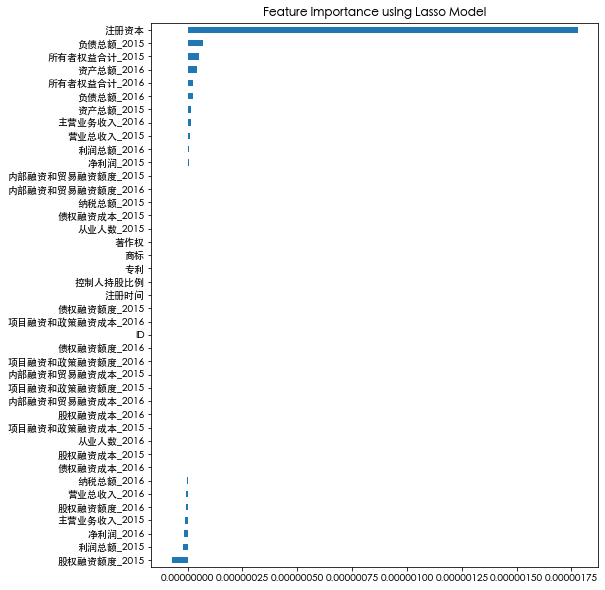

In [65]:
imp_coef = coef.sort_values()
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")

In [66]:
train_X_11 = train_X[['注册资本', '资产总额_2015', '负债总额_2015', '营业总收入_2015', '主营业务收入_2015',
       '利润总额_2015', '净利润_2015', '纳税总额_2015', '所有者权益合计_2015', '股权融资额度_2015',
       '内部融资和贸易融资额度_2015', '资产总额_2016', '负债总额_2016', '营业总收入_2016',
       '主营业务收入_2016', '利润总额_2016', '净利润_2016', '纳税总额_2016', '所有者权益合计_2016',
       '股权融资额度_2016', '内部融资和贸易融资额度_2016']]
valid_X_11 = valid_X[['注册资本', '资产总额_2015', '负债总额_2015', '营业总收入_2015', '主营业务收入_2015',
       '利润总额_2015', '净利润_2015', '纳税总额_2015', '所有者权益合计_2015', '股权融资额度_2015',
       '内部融资和贸易融资额度_2015', '资产总额_2016', '负债总额_2016', '营业总收入_2016',
       '主营业务收入_2016', '利润总额_2016', '净利润_2016', '纳税总额_2016', '所有者权益合计_2016',
       '股权融资额度_2016', '内部融资和贸易融资额度_2016']]
test_X_11 = test[['注册资本', '资产总额_2015', '负债总额_2015', '营业总收入_2015', '主营业务收入_2015',
       '利润总额_2015', '净利润_2015', '纳税总额_2015', '所有者权益合计_2015', '股权融资额度_2015',
       '内部融资和贸易融资额度_2015', '资产总额_2016', '负债总额_2016', '营业总收入_2016',
       '主营业务收入_2016', '利润总额_2016', '净利润_2016', '纳税总额_2016', '所有者权益合计_2016',
       '股权融资额度_2016', '内部融资和贸易融资额度_2016']]

In [67]:
_ = train_xgb(train_X_11, train_y, valid_X_11, valid_y, test_X_11, 'xgb_11') # 0.038951 

Mean Absolute Error(平均绝对误差): 0.038951
Mean Absolute Percentage Error(平均绝对百分比误差): 14.589075
Mean Squared Error(均方误差): 0.004227
Root Squared Error(均方根误差): 0.065016
r-2 score: 0.087998


In [68]:
# LightGBM
_ = train_gbm(train_X_11, train_y, valid_X_11, valid_y, test_X_11, 'gbm_11') # 0.041722  又大了。。

[1]	valid_0's l1: 0.0417218	valid_0's l2: 0.00462618	valid_0's auc: 1
Training until validation scores don't improve for 1000 rounds.
[2]	valid_0's l1: 0.0416697	valid_0's l2: 0.00461906	valid_0's auc: 1
[3]	valid_0's l1: 0.0416123	valid_0's l2: 0.00461038	valid_0's auc: 1
[4]	valid_0's l1: 0.041556	valid_0's l2: 0.0046019	valid_0's auc: 1


/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[5]	valid_0's l1: 0.0415014	valid_0's l2: 0.00459382	valid_0's auc: 1
[6]	valid_0's l1: 0.0414399	valid_0's l2: 0.00458563	valid_0's auc: 1
[7]	valid_0's l1: 0.0413893	valid_0's l2: 0.00457775	valid_0's auc: 1
[8]	valid_0's l1: 0.0413317	valid_0's l2: 0.00457	valid_0's auc: 1
[9]	valid_0's l1: 0.0412732	valid_0's l2: 0.00456226	valid_0's auc: 1
[10]	valid_0's l1: 0.0412175	valid_0's l2: 0.00455381	valid_0's auc: 1
[11]	valid_0's l1: 0.0411591	valid_0's l2: 0.00454565	valid_0's auc: 1
[12]	valid_0's l1: 0.0411037	valid_0's l2: 0.00453663	valid_0's auc: 1
[13]	valid_0's l1: 0.0410485	valid_0's l2: 0.00452934	valid_0's auc: 1
[14]	valid_0's l1: 0.040989	valid_0's l2: 0.00452127	valid_0's auc: 1
[15]	valid_0's l1: 0.040934	valid_0's l2: 0.00451435	valid_0's auc: 1
[16]	valid_0's l1: 0.0408814	valid_0's l2: 0.0045072	valid_0's auc: 1
[17]	valid_0's l1: 0.0408314	valid_0's l2: 0.00450015	valid_0's auc: 1
[18]	valid_0's l1: 0.0407811	valid_0's l2: 0.00449301	valid_0's auc: 1
[19]	valid_0's l1

[122]	valid_0's l1: 0.0383745	valid_0's l2: 0.0042217	valid_0's auc: 1
[123]	valid_0's l1: 0.0383687	valid_0's l2: 0.00422139	valid_0's auc: 1
[124]	valid_0's l1: 0.0383602	valid_0's l2: 0.0042201	valid_0's auc: 1
[125]	valid_0's l1: 0.0383503	valid_0's l2: 0.00421913	valid_0's auc: 1
[126]	valid_0's l1: 0.0383453	valid_0's l2: 0.00421911	valid_0's auc: 1
[127]	valid_0's l1: 0.0383372	valid_0's l2: 0.0042185	valid_0's auc: 1
[128]	valid_0's l1: 0.0383325	valid_0's l2: 0.00421844	valid_0's auc: 1
[129]	valid_0's l1: 0.0383228	valid_0's l2: 0.00421735	valid_0's auc: 1
[130]	valid_0's l1: 0.038315	valid_0's l2: 0.00421651	valid_0's auc: 1
[131]	valid_0's l1: 0.0383096	valid_0's l2: 0.0042156	valid_0's auc: 1
[132]	valid_0's l1: 0.0383041	valid_0's l2: 0.00421497	valid_0's auc: 1
[133]	valid_0's l1: 0.0382968	valid_0's l2: 0.00421406	valid_0's auc: 1
[134]	valid_0's l1: 0.0382881	valid_0's l2: 0.00421324	valid_0's auc: 1
[135]	valid_0's l1: 0.0382815	valid_0's l2: 0.00421238	valid_0's auc:

[251]	valid_0's l1: 0.038081	valid_0's l2: 0.00421156	valid_0's auc: 1
[252]	valid_0's l1: 0.0380818	valid_0's l2: 0.00421171	valid_0's auc: 1
[253]	valid_0's l1: 0.0380857	valid_0's l2: 0.00421193	valid_0's auc: 1
[254]	valid_0's l1: 0.0380869	valid_0's l2: 0.00421229	valid_0's auc: 1
[255]	valid_0's l1: 0.0380923	valid_0's l2: 0.00421329	valid_0's auc: 1
[256]	valid_0's l1: 0.0380892	valid_0's l2: 0.00421237	valid_0's auc: 1
[257]	valid_0's l1: 0.03809	valid_0's l2: 0.00421289	valid_0's auc: 1
[258]	valid_0's l1: 0.0380871	valid_0's l2: 0.00421343	valid_0's auc: 1
[259]	valid_0's l1: 0.0380886	valid_0's l2: 0.004214	valid_0's auc: 1
[260]	valid_0's l1: 0.038091	valid_0's l2: 0.00421449	valid_0's auc: 1
[261]	valid_0's l1: 0.0380913	valid_0's l2: 0.0042147	valid_0's auc: 1
[262]	valid_0's l1: 0.0380923	valid_0's l2: 0.00421553	valid_0's auc: 1
[263]	valid_0's l1: 0.0380939	valid_0's l2: 0.00421639	valid_0's auc: 1
[264]	valid_0's l1: 0.0380934	valid_0's l2: 0.00421645	valid_0's auc: 1

[391]	valid_0's l1: 0.0380517	valid_0's l2: 0.0042251	valid_0's auc: 1
[392]	valid_0's l1: 0.038057	valid_0's l2: 0.0042254	valid_0's auc: 1
[393]	valid_0's l1: 0.0380589	valid_0's l2: 0.00422481	valid_0's auc: 1
[394]	valid_0's l1: 0.0380622	valid_0's l2: 0.00422516	valid_0's auc: 1
[395]	valid_0's l1: 0.038063	valid_0's l2: 0.00422492	valid_0's auc: 1
[396]	valid_0's l1: 0.0380653	valid_0's l2: 0.00422477	valid_0's auc: 1
[397]	valid_0's l1: 0.0380667	valid_0's l2: 0.00422457	valid_0's auc: 1
[398]	valid_0's l1: 0.0380678	valid_0's l2: 0.00422459	valid_0's auc: 1
[399]	valid_0's l1: 0.0380672	valid_0's l2: 0.00422422	valid_0's auc: 1
[400]	valid_0's l1: 0.0380677	valid_0's l2: 0.00422408	valid_0's auc: 1
[401]	valid_0's l1: 0.038067	valid_0's l2: 0.00422412	valid_0's auc: 1
[402]	valid_0's l1: 0.0380656	valid_0's l2: 0.00422408	valid_0's auc: 1
[403]	valid_0's l1: 0.0380683	valid_0's l2: 0.00422478	valid_0's auc: 1
[404]	valid_0's l1: 0.0380702	valid_0's l2: 0.00422515	valid_0's auc:

[543]	valid_0's l1: 0.0381385	valid_0's l2: 0.00424955	valid_0's auc: 1
[544]	valid_0's l1: 0.0381402	valid_0's l2: 0.00424981	valid_0's auc: 1
[545]	valid_0's l1: 0.0381412	valid_0's l2: 0.0042505	valid_0's auc: 1
[546]	valid_0's l1: 0.0381418	valid_0's l2: 0.0042508	valid_0's auc: 1
[547]	valid_0's l1: 0.0381432	valid_0's l2: 0.00425132	valid_0's auc: 1
[548]	valid_0's l1: 0.0381451	valid_0's l2: 0.00425255	valid_0's auc: 1
[549]	valid_0's l1: 0.038145	valid_0's l2: 0.00425306	valid_0's auc: 1
[550]	valid_0's l1: 0.0381486	valid_0's l2: 0.00425409	valid_0's auc: 1
[551]	valid_0's l1: 0.0381501	valid_0's l2: 0.00425422	valid_0's auc: 1
[552]	valid_0's l1: 0.0381479	valid_0's l2: 0.00425375	valid_0's auc: 1
[553]	valid_0's l1: 0.0381474	valid_0's l2: 0.00425327	valid_0's auc: 1
[554]	valid_0's l1: 0.0381499	valid_0's l2: 0.00425363	valid_0's auc: 1
[555]	valid_0's l1: 0.0381499	valid_0's l2: 0.00425386	valid_0's auc: 1
[556]	valid_0's l1: 0.0381493	valid_0's l2: 0.00425367	valid_0's au

[684]	valid_0's l1: 0.0381803	valid_0's l2: 0.00426687	valid_0's auc: 1
[685]	valid_0's l1: 0.0381782	valid_0's l2: 0.00426672	valid_0's auc: 1
[686]	valid_0's l1: 0.0381776	valid_0's l2: 0.0042667	valid_0's auc: 1
[687]	valid_0's l1: 0.038177	valid_0's l2: 0.00426655	valid_0's auc: 1
[688]	valid_0's l1: 0.0381777	valid_0's l2: 0.004267	valid_0's auc: 1
[689]	valid_0's l1: 0.0381767	valid_0's l2: 0.00426695	valid_0's auc: 1
[690]	valid_0's l1: 0.0381775	valid_0's l2: 0.00426746	valid_0's auc: 1
[691]	valid_0's l1: 0.0381784	valid_0's l2: 0.00426815	valid_0's auc: 1
[692]	valid_0's l1: 0.0381814	valid_0's l2: 0.00426838	valid_0's auc: 1
[693]	valid_0's l1: 0.0381804	valid_0's l2: 0.0042686	valid_0's auc: 1
[694]	valid_0's l1: 0.0381839	valid_0's l2: 0.00426925	valid_0's auc: 1
[695]	valid_0's l1: 0.0381873	valid_0's l2: 0.00426951	valid_0's auc: 1
[696]	valid_0's l1: 0.0381893	valid_0's l2: 0.00426989	valid_0's auc: 1
[697]	valid_0's l1: 0.0381904	valid_0's l2: 0.00427023	valid_0's auc:

[832]	valid_0's l1: 0.0381903	valid_0's l2: 0.0042944	valid_0's auc: 1
[833]	valid_0's l1: 0.0381932	valid_0's l2: 0.00429489	valid_0's auc: 1
[834]	valid_0's l1: 0.038195	valid_0's l2: 0.00429495	valid_0's auc: 1
[835]	valid_0's l1: 0.0381983	valid_0's l2: 0.00429571	valid_0's auc: 1
[836]	valid_0's l1: 0.0381998	valid_0's l2: 0.00429594	valid_0's auc: 1
[837]	valid_0's l1: 0.0382003	valid_0's l2: 0.00429595	valid_0's auc: 1
[838]	valid_0's l1: 0.038203	valid_0's l2: 0.00429599	valid_0's auc: 1
[839]	valid_0's l1: 0.0382049	valid_0's l2: 0.00429558	valid_0's auc: 1
[840]	valid_0's l1: 0.0382044	valid_0's l2: 0.00429587	valid_0's auc: 1
[841]	valid_0's l1: 0.0382021	valid_0's l2: 0.00429581	valid_0's auc: 1
[842]	valid_0's l1: 0.0382003	valid_0's l2: 0.00429575	valid_0's auc: 1
[843]	valid_0's l1: 0.0381978	valid_0's l2: 0.00429576	valid_0's auc: 1
[844]	valid_0's l1: 0.0381974	valid_0's l2: 0.00429572	valid_0's auc: 1
[845]	valid_0's l1: 0.0381954	valid_0's l2: 0.00429546	valid_0's au

[988]	valid_0's l1: 0.038266	valid_0's l2: 0.00432051	valid_0's auc: 1
[989]	valid_0's l1: 0.038267	valid_0's l2: 0.0043208	valid_0's auc: 1
[990]	valid_0's l1: 0.0382687	valid_0's l2: 0.00432082	valid_0's auc: 1
[991]	valid_0's l1: 0.0382701	valid_0's l2: 0.004322	valid_0's auc: 1
[992]	valid_0's l1: 0.0382714	valid_0's l2: 0.00432279	valid_0's auc: 1
[993]	valid_0's l1: 0.0382725	valid_0's l2: 0.00432391	valid_0's auc: 1
[994]	valid_0's l1: 0.0382732	valid_0's l2: 0.00432487	valid_0's auc: 1
[995]	valid_0's l1: 0.0382732	valid_0's l2: 0.00432549	valid_0's auc: 1
[996]	valid_0's l1: 0.0382771	valid_0's l2: 0.0043272	valid_0's auc: 1
[997]	valid_0's l1: 0.0382771	valid_0's l2: 0.004328	valid_0's auc: 1
[998]	valid_0's l1: 0.0382787	valid_0's l2: 0.00432831	valid_0's auc: 1
[999]	valid_0's l1: 0.0382793	valid_0's l2: 0.00432911	valid_0's auc: 1
[1000]	valid_0's l1: 0.0382836	valid_0's l2: 0.00433082	valid_0's auc: 1
Did not meet early stopping. Best iteration is:
[389]	valid_0's l1: 0.0

In [69]:
# Linear Regression
_ = train_lr(train_X_11, train_y, valid_X_11, valid_y, test_X_11, 'lr_11') # 0.037765 全场最佳！？

Mean Absolute Error(平均绝对误差): 0.037765
Mean Absolute Percentage Error(平均绝对百分比误差): 13.963803
Mean Squared Error(均方误差): 0.004187
Root Squared Error(均方根误差): 0.064707
r-2 score: 0.096655


In [70]:
name,                     MSE,    RMSE,                MAE
谭凯悦+201952110323_lr_11, 0.0069, 0.08306623862918075, 0.0696

SyntaxError: invalid token (<ipython-input-70-145c4890ef0b>, line 2)